In [1]:
import sys
!{sys.executable} -m pip install plotly-express


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from statsmodels.stats import diagnostic
from scipy import stats
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import os

In [3]:
#Add state code 
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <center>We're a consulting firm for breweries. Breweries give us their reviews and ask us to design their marketing campaign. </center>

# **Introduction** 

Let's say you own a brewery and you want to enter the American beer market. You were previously selling your beer in other countries and have gathered a lot of reviews on your beers. Now you want to use these reviews to design your marketing campaign in the US. 

In particular, you ask yourself:

- Will my beer be a <b>unique</b> product in the American market ? Are there beers <b>similar</b> to mine ? 
> <b> `Motivation` </b>: You want to know this in order to understand the competition you stand against. Moreover, it will help you measure how substitutable your beer is. If your beer will be unique and original in a particular state then you should market it in that state, but if its very similar to another beer then don't market it there because there's a lot of competition.

- What is the <b>most succesful</b> beer per state ? What is the aspect in which these beers excel (taste, palate) ?
> <b> `Motivation` </b>: You want to know this to understand the strength and weakness of your competitors.

- What <b>aspects of the beer profile</b> are most important (is taste more important than palate) ? 
> <b> `Motivation` </b>: You want to know this to focus your marketing on the relevant aspect. For instance, if Californians don't care about the appearance of the beer, then you shouldn't spend resources creating a nice design for your beer, focus more on the taste or palate.

- Among the beers we are most similar to, which ones can we beat ? For instance, is there a beer whose profile is similar to ours <b>but we are better in one aspect</b>? 
> <b> `Motivation` </b>: Let's say there is beer X that is very similar to ours: we score the same ratings on palate, taste and appearance. However, we notice that our aroma ratings are much higher than theirs. Then we can definitely kick beer X out of the market and win their share of beer sales. We can do this by finding where beer X is most popular and sell our product there. Consumers will find our product to be similar to beer X but has better aroma. The opposite scenario is that we are beer X. Meaning there is a competitor that is similar to us but is better in one aspect. We should be careful to not market our product in the same state as this competitor because we might lose our share of beer sales to them. 

So you turn to your team of data analysts (that's us) and you ask us to dive into the dataset and answer these questions. First, we start by translating these business questions into questions we can answer using the data. We suggest the following questions as proxies for the business needs of our brewery:

### Problem statement:
- How do we find the beers that are similar to ours ? How do we even measure <i>closeness</i> of beers ?
- How do we know which aspect is <i>important</i> for a beer aspect ?
- How do you measure the success of a certain beer ?

### Suggested solutions:
- We need to represent beers in a space that has a notion of <b> distance </b>. If we can represent each beer as a vector, then we can run <b>clustering algorithms like `K-Means`</b> to find beers that are similar to each other. Or we can run <b> `K-Nearest Neighbours` </b> to find the beers that are most similar to ours. On the same note, we can draw the <b> word-cloud </b> of the textual reviews associated to the beer, it will give the most commonly mentioned words. 

- For each beer we can run <b>`linear regression`</b> and compare the coefficients associated to each aspect. We start by learning a function $rating = w_1*palate + w_2*taste + w_3*aroma + w_4*appearance$. If $w_3$ is the biggest coefficient, then it is the most decisive aspect of the beer rating (i.e people care about the aroma aspect). We can add <b>`Lasso`</b> regularisation so that the unimportant coefficients are set automatically to zero.

- Measuring the success of a beer is simple, we just look at the proportion of high ratings. 

The first part of the notebook is dedicated to the classification task. We want to map each beer profile (taste, appearance, etc) to the state in which it is most popular. Later we can use this classifier to know in which state to market a certain beer given its profile. 

## **Data preprocessing**

During this step, we will **pre-process all the csv files** and **extract all the informations** needed for our project.

In [5]:
# Load files

# Ratings overview (with informations extracted from the files ratings.txt)
ratings_overview_rb = pd.read_csv('/content/drive/MyDrive/data/RateBeer/ratings_overview_rb.csv', delimiter=',')
ratings_overview_ba = pd.read_csv('/content/drive/MyDrive/data/BeerAdvocate/ratings_overview_ba.csv', delimiter=',')

# Users
users_rb = pd.read_csv('/content/drive/MyDrive/data/RateBeer/users_rb.csv', delimiter=',')
users_ba = pd.read_csv('/content/drive/MyDrive/data/BeerAdvocate/users_ba.csv', delimiter=',')

# Beers
beers_rb = pd.read_csv('/content/drive/MyDrive/data/RateBeer/beers_rb.csv', delimiter=',')
beers_ba = pd.read_csv('/content/drive/MyDrive/data/BeerAdvocate/beers_ba.csv', delimiter=',')

# Breweries
breweries_rb = pd.read_csv('/content/drive/MyDrive/data/RateBeer/breweries_rb.csv', delimiter=',')
breweries_ba = pd.read_csv('/content/drive/MyDrive/data/BeerAdvocate/breweries_ba.csv', delimiter=',')

In [6]:
# Define the color associated with our project
shade1 = '#fccc1c'
shade2 = '#ddb318'
shade3 = '#bd9915'
shade4 = '#9e8011'
shade5 = '#7e660e'
shade6 = '#5f4d0a'
shade7 = '#3f3307'
shade8 = '#201a03'

rb_color = shade1
ba_color = shade4

blue = '#7ed6df'
light_blue = '#c7ecee'
dark_plue = '#30336b'
red = '#ff7979'
orange = '#ffbe76'
purple = '#e056fd'
green = '#badc58'


### **1. Retrieve informations from the ratings.txt file**

In order to get informations about each rating on Beer Advocate and Rate Beer, we will extract the following features from the files `ratings_ba.txt` and `ratings_rb.txt` : 

*   Beer Id
*   Date of rating 
*   Rating
*   Appearance, aroma, palate, taste, overall




 

In [7]:
def extract_ids_dates_ratings(file_folder, nb_iters_start, nb_iters_stop):
    """
    To extract the beer_id and the date from the file ratings.txt. 
    First, do not forget to run 'split -l 500000 -d --additional-suffix=.txt $FileName ratings.txt'

    Args : 
    file_folder : name of the folder you have your splitted files
    nb_iters_start : number of the first splitted file you want to extract
    nb_iters_stop : number of the last splitted file you want to extract

    Returns : 
    beer_ids : list of the beer_ids extracted 
    beer_dates : list of the dates of the ratings extracted
    """
    beer_ids = []
    beer_dates = []
    user_ids = []
    appearance = []
    aroma = []
    palate = []
    taste = []
    overall = []
    rating = []

    for i in range(nb_iters_start, nb_iters_stop) :
        if i < 10 :
            name = file_folder + '/x0' + str(i) +'.txt'
        else : 
            name = file_folder + '/x' + str(i) +'.txt'

        fic = open(name, mode='r', encoding='utf-8')
        for line in fic : 
            if line.startswith('beer_id') :
                split = line.split()
                beer_ids.append(split[1])

            if line.startswith('date') :
                split = line.split()
                beer_dates.append(split[1])

            if line.startswith('user_id') : 
                split = line.split()
                user_ids.append(split[1])

            if line.startswith('appearance') : 
                split = line.split()
                appearance.append(split[1])

            if line.startswith('aroma') : 
                split = line.split()
                aroma.append(split[1])

            if line.startswith('palate') : 
                split = line.split()
                palate.append(split[1])

            if line.startswith('taste') : 
                split = line.split()
                taste.append(split[1])

            if line.startswith('overall') : 
                split = line.split()
                overall.append(split[1])

            if line.startswith('rating') : 
                split = line.split()
                rating.append(split[1])

        fic.close()
        os.remove(name)
    return beer_ids, beer_dates, user_ids, appearance, aroma, palate, taste, overall, rating

The databases are already created and you **don't need to run the following cells**. You can find them at the following location :   


*   /content/drive/MyDrive/data/BeerAdvocate/ratings_overview_ba.csv
*  /content/drive/MyDrive/data/RateBeer/ratings_overview_rb.csv



In [8]:
#For RateBeer
#Run the following lines to create the database and save it to csv.
"""!split -l 500000 -d --additional-suffix=.txt $FileName /content/drive/MyDrive/data/RateBeer/ratings_rb.txt
file_folder = '/content/'
beer_ids, beer_dates, user_ids, appearance, aroma, palate, taste, overall, rating = extract_ids_dates_ratings(file_folder, 0, 90)
beer_ids2, beer_dates2, user_ids2, appearance2, aroma2, palate2, taste2, overall2, rating2 = extract_ids_dates_ratings(file_folder, 9000, 9153)

ratings_data_rb = pd.DataFrame({
                            'beer_id' : beer_ids + beer_ids2,
                            'dates' : beer_dates + beer_dates2,
                            'user_ids' :user_ids + user_ids2,
                            'appearance' : appearance + appearance2,
                            'aroma' : aroma + aroma2, 
                            'palate' : palate + palate2, 
                            'taste' : taste + taste2, 
                            'overall' : overall + overall2, 
                            'rating' : rating + rating2
                            })

ratings_data_rb['dates'] = pd.to_datetime(ratings_data_rb['dates'],unit='s')
ratings_data_rb.to_csv('/content/drive/MyDrive/data/RateBeer/ratings_overview_rb.csv', index=False)"""

"!split -l 500000 -d --additional-suffix=.txt $FileName /content/drive/MyDrive/data/RateBeer/ratings_rb.txt\nfile_folder = '/content/'\nbeer_ids, beer_dates, user_ids, appearance, aroma, palate, taste, overall, rating = extract_ids_dates_ratings(file_folder, 0, 90)\nbeer_ids2, beer_dates2, user_ids2, appearance2, aroma2, palate2, taste2, overall2, rating2 = extract_ids_dates_ratings(file_folder, 9000, 9153)\n\nratings_data_rb = pd.DataFrame({\n                            'beer_id' : beer_ids + beer_ids2,\n                            'dates' : beer_dates + beer_dates2,\n                            'user_ids' :user_ids + user_ids2,\n                            'appearance' : appearance + appearance2,\n                            'aroma' : aroma + aroma2, \n                            'palate' : palate + palate2, \n                            'taste' : taste + taste2, \n                            'overall' : overall + overall2, \n                            'rating' : rating + rating2\n 

In [9]:
#For Beer Advocate
#Run the following lines to create the database and save it to csv.
"""!split -l 500000 -d --additional-suffix=.txt $FileName /content/drive/MyDrive/data/BeerAdvocate/ratings_ba.txt
file_folder = '/content/'
beer_ids, beer_dates, user_ids, appearance, aroma, palate, taste, overall, rating = extract_ids_dates_ratings(file_folder, 0, 90)
beer_ids2, beer_dates2, user_ids2, appearance2, aroma2, palate2, taste2, overall2, rating2 = extract_ids_dates_ratings(file_folder, 9000, 9213)

ratings_data_rb = pd.DataFrame({
                            'beer_id' : beer_ids + beer_ids2,
                            'dates' : beer_dates + beer_dates2,
                            'user_ids' :user_ids + user_ids2,
                            'appearance' : appearance + appearance2,
                            'aroma' : aroma + aroma2, 
                            'palate' : palate + palate2, 
                            'taste' : taste + taste2, 
                            'overall' : overall + overall2, 
                            'rating' : rating + rating2
                            })

ratings_data_rb['dates'] = pd.to_datetime(ratings_data_rb['dates'],unit='s')
ratings_data_rb.to_csv('/content/drive/MyDrive/data/BeerAdvocate/ratings_overview_ba.csv', index=False)"""

"!split -l 500000 -d --additional-suffix=.txt $FileName /content/drive/MyDrive/data/BeerAdvocate/ratings_ba.txt\nfile_folder = '/content/'\nbeer_ids, beer_dates, user_ids, appearance, aroma, palate, taste, overall, rating = extract_ids_dates_ratings(file_folder, 0, 90)\nbeer_ids2, beer_dates2, user_ids2, appearance2, aroma2, palate2, taste2, overall2, rating2 = extract_ids_dates_ratings(file_folder, 9000, 9213)\n\nratings_data_rb = pd.DataFrame({\n                            'beer_id' : beer_ids + beer_ids2,\n                            'dates' : beer_dates + beer_dates2,\n                            'user_ids' :user_ids + user_ids2,\n                            'appearance' : appearance + appearance2,\n                            'aroma' : aroma + aroma2, \n                            'palate' : palate + palate2, \n                            'taste' : taste + taste2, \n                            'overall' : overall + overall2, \n                            'rating' : rating + rating

### **2. Extract the user_id for Beer Advocate** 

In BeerAdvocate's ratings and users datasets, the `user_id` is a string composed of the `user_name` and the `user_id` in the following format : "user_name.user_id". 
<br>Therefore, we will split the column to **extract the user_id**.
<br>*Note: we do not need to keep the user_name because that information is already contained in the users dataset and it is **much less heavy to compare integers than strings**.*

In [10]:
ratings_overview_ba.head()

,beer_id,dates,user_ids,appearance,aroma,palate,taste,overall,rating
0,142544,2015-08-20 10:00:00,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88
1,19590,2009-02-20 11:00:00,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67
2,19590,2006-03-13 11:00:00,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73
3,19590,2004-12-01 11:00:00,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98
4,19590,2004-08-30 10:00:00,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00


In [11]:
ratings_overview_ba['user_ids'].head()

0           nmann08.184925
1       stjamesgate.163714
2            mdagnew.19527
3    helloloser12345.10867
4          cypressbob.3708
Name: user_ids, dtype: object

Unfortunately, some ratings **only contain the user_name**.

In [12]:
# Extracting the user_id from BeerAdvocate's ratings
N, D = ratings_overview_ba.shape
str_users_id = ratings_overview_ba['user_ids'].astype(str)
new_users_id = list()
missing_id = dict()

print("Line num: user_id --> split user_id")

for i in range(N):
    r = str_users_id[i]
    r_split = r.split('.')
    
    # Print and Store the missing values
    if len(r_split) < 2 or r_split[1] == '':
        print("{:d}: {} --> {}".format(i, r, r_split))
        missing_id[i] = r_split[0]
        new_users_id.append(np.nan)
    
    else:
        new_users_id.append(int(r_split[1]))

Line num: user_id --> split user_id
467624: bros2hoes --> ['bros2hoes']
2893205: bros2hoes --> ['bros2hoes']
8292137: bros2hoes --> ['bros2hoes']


There is only one user of which we know the `user_name` but not the `user_id`. We will look if that information is contained into the users dataframe.

In [13]:
users_ba[users_ba['user_name'].astype(str) == 'bros2hoes']

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location


Unfortunately, we **could not find the user**, therefore we won't be able to use his ratings because we cannot rely him to a country.

But as we can see above there is only 3 lines for 'bros2hoes' in the ratings. It means that this user **only posted 3 ratings** on BeerAdvocate.
As we have more than 8 billions of ratings we can say that it **won't affect our results**. Hence, we will delete the ratings edited by `bros2hoes`. 

To finish, we will change the old user_id by the new user_id in the `ratings_overview` and in the `users` datasets. 

In [14]:
#In ratings_overview dataset
ratings_overview_ba['user_ids'] = new_users_id

#In users dataset
N, D = users_ba.shape
str_users_id = users_ba['user_id'].astype(str)
new_users_id = list()

for i in range(N):
    r = str_users_id[i]
    r_split = r.split('.')
    new_users_id.append(int(r_split[1]))

users_ba['user_id'] = new_users_id

There is also one user whose user_name was not converted from html. We will set a new name and sum the nbr_ratings to get only one line from that user. 

In [15]:
user_to_change = users_rb.loc[users_rb['user_id'] == 46797]

index_rows = user_to_change.index
index_rows_to_delete = index_rows[1:]
index_row_to_keep = index_rows[0]

nbr_total_ratings = user_to_change.nbr_ratings.sum()
users_rb.at[index_row_to_keep,'nbr_ratings']=nbr_total_ratings
users_rb = users_rb.drop(labels=index_rows_to_delete, axis=0)

users_rb.loc[users_rb['user_id'] == 46797]

,nbr_ratings,user_id,user_name,joined,location
1176,44,46797,"<span class=""__cf_email__"" data-cfemail=""2b494...",1.166526e+09,"United States, Arkansas"


### **3. Retrieve dates of ratings and user_id for each beer and merge to beers dataset**

Now that we retrieved informations about each rating, we will merge the dates and user_ids to the beers dataset. 
<br> For that, we will **group** the ratings by **beer_id**, **agglomerate** all the dates/user_ids in two different **lists** and **add** them to the **beers_ba** and **beers_rb** files through new columns. 

In [16]:
#To be sure we have the good type for the dates
ratings_overview_rb['dates'] = pd.to_datetime(ratings_overview_rb.dates, infer_datetime_format=True) 
ratings_overview_ba['dates'] = pd.to_datetime(ratings_overview_ba.dates, infer_datetime_format=True)  

#Only keep the beer_id and the date of rating
beer_dates_rb = ratings_overview_rb.groupby(["beer_id"]).apply(lambda x : list(x['dates']))
beer_dates_ba = ratings_overview_ba.groupby(["beer_id"]).apply(lambda x : list(x['dates']))

#Keep only the beer_id and the user_id of rating
beer_users_rb = ratings_overview_rb.groupby(["beer_id"]).apply(lambda x : list(x['user_ids']))
beer_users_ba = ratings_overview_ba.groupby(["beer_id"]).apply(lambda x : list(x['user_ids']))

#Create two dataframes and merge to beers dataset 
beer_dates_rb = pd.DataFrame({'beer_id' : beer_dates_rb.index, 'dates' : beer_dates_rb.values})
beer_users_rb = pd.DataFrame({'beer_id' : beer_users_rb.index, 'user_ids' : beer_users_rb.values})
beers_rb = pd.merge(beers_rb, beer_dates_rb, how='inner', on=['beer_id'])
beers_rb = pd.merge(beers_rb, beer_users_rb, how='inner', on=['beer_id'])

beer_dates_ba = pd.DataFrame({'beer_id' : beer_dates_ba.index, 'dates' : beer_dates_ba.values})
beer_users_ba = pd.DataFrame({'beer_id' : beer_users_ba.index, 'user_ids' : beer_users_ba.values})
beers_ba = pd.merge(beers_ba, beer_dates_ba, how='inner', on=['beer_id'])
beers_ba = pd.merge(beers_ba, beer_users_ba, how='inner', on=['beer_id'])

### **4. Merge breweries and beers files**

We add the **location of breweries** and the **number of beers** they propose into the files **beers_ba** and **beers_rb**.

In [17]:
breweries_rb_tmp = breweries_rb[['id', 'location', 'nbr_beers']]
breweries_rb_tmp = breweries_rb_tmp.rename(columns = {'id' : 'brewery_id'})
beers_rb = pd.merge(beers_rb, breweries_rb_tmp, how='inner', on=['brewery_id'])

breweries_ba_tmp = breweries_rb[['id', 'location', 'nbr_beers']]
breweries_ba_tmp = breweries_rb_tmp.rename(columns = {'id' : 'brewery_id'})
beers_ba = pd.merge(beers_ba, breweries_ba_tmp, how='inner', on=['brewery_id'])

### **5. Convert ratings to float**

There are some values in the rating column from BeerAdvocate ratings that don't have a float type. Hence, we will convert them in order to work with them later. 

In [18]:
# We look for the unconvertible values
for i in range(ratings_overview_ba.shape[0]):
    r = ratings_overview_ba['rating'].iloc[i]
    if not type(r) == float:
        try:
            float(r)
        except ValueError:
            print('line {:d}: {:s} could not be converted into float'.format(i, r))

### **6. Deal with unknown locations for users**

We replace the unknown locations (that are represented by nan) by the string 'no_country' so that we can treat all locations as str.

In [19]:
# Replace nan values in the location by a str
users_rb['location'] = users_rb['location'].fillna('no_country')
users_ba['location'] = users_ba['location'].fillna('no_country')

## **Part 1 - First insights from the beer reviews websites** 

We have chosen to base our market analysis on two beer review sites: **Beer Advocate** and **Rate Beer**. <br> These two sites are widely considered the go-to beer resource for millions of consumers each month and the benchmark for beer reviews. 
<br>Indeed, in order to **understand the demand of our customers** and to **adapt our offer** as well as possible, isn't it worth **getting information directly from them** ?

We start our work with a first **data exploratory** of the two websites to understand the **evolution of the beer industry** over the last years as well as the **behavior of beer consumers**.

###**From where the customers are coming from ?**

First of all, we will **count the number of ratings per country** in order to see **from where the customers are coming from**. 

In [20]:
# Count the number of ratings per country
def count_ratings_per_country(user_data, ratings_data, verbose=False):
    """
    Args:
        user_data: pd.Dataframe - user df
            must contain 'location' and 'user_id'
        ratings_data: pd.DataFrame - ratings df
            must contain 'user_id'
        
    Returns:
        countries: list[str] - list of the countries
        nbr_ratings_per_country: list[int] - number of ratings per country
            for each i, nbr_ratings_per_country[i] contains the number of ratings from users of the country countries[i]
    """
    countries = user_data.location.unique()
    nbr_ratings_per_country = list()

    for country in countries:
        if verbose:
            print(country, end='\t')
        users_id = user_data.groupby('location').get_group(country)['user_id'].unique()
        cpt = 0

        ratings = ratings_data[ratings_data['user_id'].isin(users_id)]
        cpt += len(ratings)

        nbr_ratings_per_country.append(cpt)
        if verbose:
            print("{:d}".format(cpt))
    return countries, nbr_ratings_per_country

In [21]:
# Count ratings per country in RateBeer

# Lines to run to get the data
#countries_rb, nbr_ratings_per_country_rb = count_ratings_per_country(users_rb, ratings_overview_rb)
#np.save('/content/drive/MyDrive/data/RateBeer/nbr_ratings_per_country.npy', np.array(nbr_ratings_per_country_rb))

# Lines to run when the data has been stored
countries_rb = users_rb.location.unique()
nbr_ratings_per_country_rb = np.load('/content/drive/MyDrive/data/RateBeer/nbr_ratings_per_country.npy')

In [22]:
# Count ratings per country in BeerAdvocate

# Lines to run to get the data
#countries_ba, nbr_ratings_per_country_ba = count_ratings_per_country(users_ba, ratings_overview_ba)
#np.save('/content/drive/MyDrive/data/BeerAdvocate/nbr_ratings_per_country.npy', np.array(nbr_ratings_per_country_ba))

# Lines to run when the data has been stored
countries_ba = users_ba.location.unique()
nbr_ratings_per_country_ba = np.load('/content/drive/MyDrive/data/BeerAdvocate/nbr_ratings_per_country.npy')

In [23]:
# Test if the # of ratings counted are appropriate
print("----RateBeer----")
a = ratings_overview_rb.shape[0]
b = sum(nbr_ratings_per_country_rb)
print(a)
print(b)
print("Number of missing ratings :", a-b)

print("")

print("----BeerAdvocate----")
a = ratings_overview_ba.shape[0]
b = sum(nbr_ratings_per_country_ba)
print(a)
print(b)
print("Number of missing ratings :", a-b)

----RateBeer----
7122074
7122050
Number of missing ratings : 24

----BeerAdvocate----
8393032
8393027
Number of missing ratings : 5


In [24]:
def group_US(countries, nbr_ratings_per_country):
    """
    Args:
        countries: list[str] - list of countries
        nbr_ratings_per_country: list[int] - number of ratings per country
    
    Hypothesis:
        len(countries) == len(nbr_ratings_per_country)
        
    Returns:
        countries_USagg: list[str] - list of countries with all countries containing the word 'United States' grouped in one
        nbr_ratings_per_country_USagg: list[int] - number of ratings per country with all US countries sum up in one
    """
    nbr_country = len(countries)
    US_i = list()
    
    # Create a list of index of the countries that contain 'United States'
    for i in range(nbr_country):
        c = countries[i]
        if 'United States' in c:
            US_i.append(i)
    
    nbr_ratings_USagg = list()
    countries_USagg = list()
    cpt_US = 0

    # For each country, 
    # if it is in US sum the number of ratngs 
    # else add country and number of ratings to the result lists
    for i in range(nbr_country):
        if i in US_i:
            cpt_US += nbr_ratings_per_country[i]
        else:
            nbr_ratings_USagg.append(nbr_ratings_per_country[i])
            countries_USagg.append(countries[i])
    
    # Add the aggregated 'United States'
    nbr_ratings_USagg.append(cpt_US)
    countries_USagg.append('United States')
    
    return countries_USagg, nbr_ratings_USagg

In [25]:
countries_USagg_rb, nbr_ratings_USagg_rb = group_US(countries_rb, nbr_ratings_per_country_rb)
countries_USagg_ba, nbr_ratings_USagg_ba = group_US(countries_ba, nbr_ratings_per_country_ba)

In [26]:
# Sort the countries by the total number of ratings on both websites
# Except US that we want to plot separately

countries = list(set(countries_USagg_rb[:-1]).union(set(countries_USagg_ba[:-1])))
nbr_country = len(countries)
total_nbr_ratings = np.zeros(nbr_country)

for i in range(nbr_country):
    country = countries[i]
    
    # Add the number of ratings in RateBeer if the country in RateBeer countries
    try:
        irb = countries_USagg_rb.index(country)
        cpt_rb = nbr_ratings_USagg_rb[irb]
    except ValueError:
        cpt_rb = 0
    
    # Add the number of ratings in BeerAdvocate if the country in BeerAdvocate countries
    try:
        iba = countries_USagg_ba.index(country)
        cpt_ba = nbr_ratings_USagg_ba[iba]
    except ValueError:
        cpt_ba = 0
        
    total_nbr_ratings[i] = cpt_rb + cpt_ba

# Sort countries
sorted_index = np.array(total_nbr_ratings).argsort()
sorted_countries = np.array(countries)[sorted_index]

# Create list of number of ratings for each website
sorted_nbr_ratings_rb = list()
sorted_nbr_ratings_ba = list()

for country in sorted_countries:
    try:
        rb = nbr_ratings_USagg_rb[countries_USagg_rb.index(country)]
    except ValueError:
        rb = 0
    sorted_nbr_ratings_rb.append(rb)
    
    try:
        ba = nbr_ratings_USagg_ba[countries_USagg_ba.index(country)]
    except ValueError:
        ba = 0
    sorted_nbr_ratings_ba.append(ba)

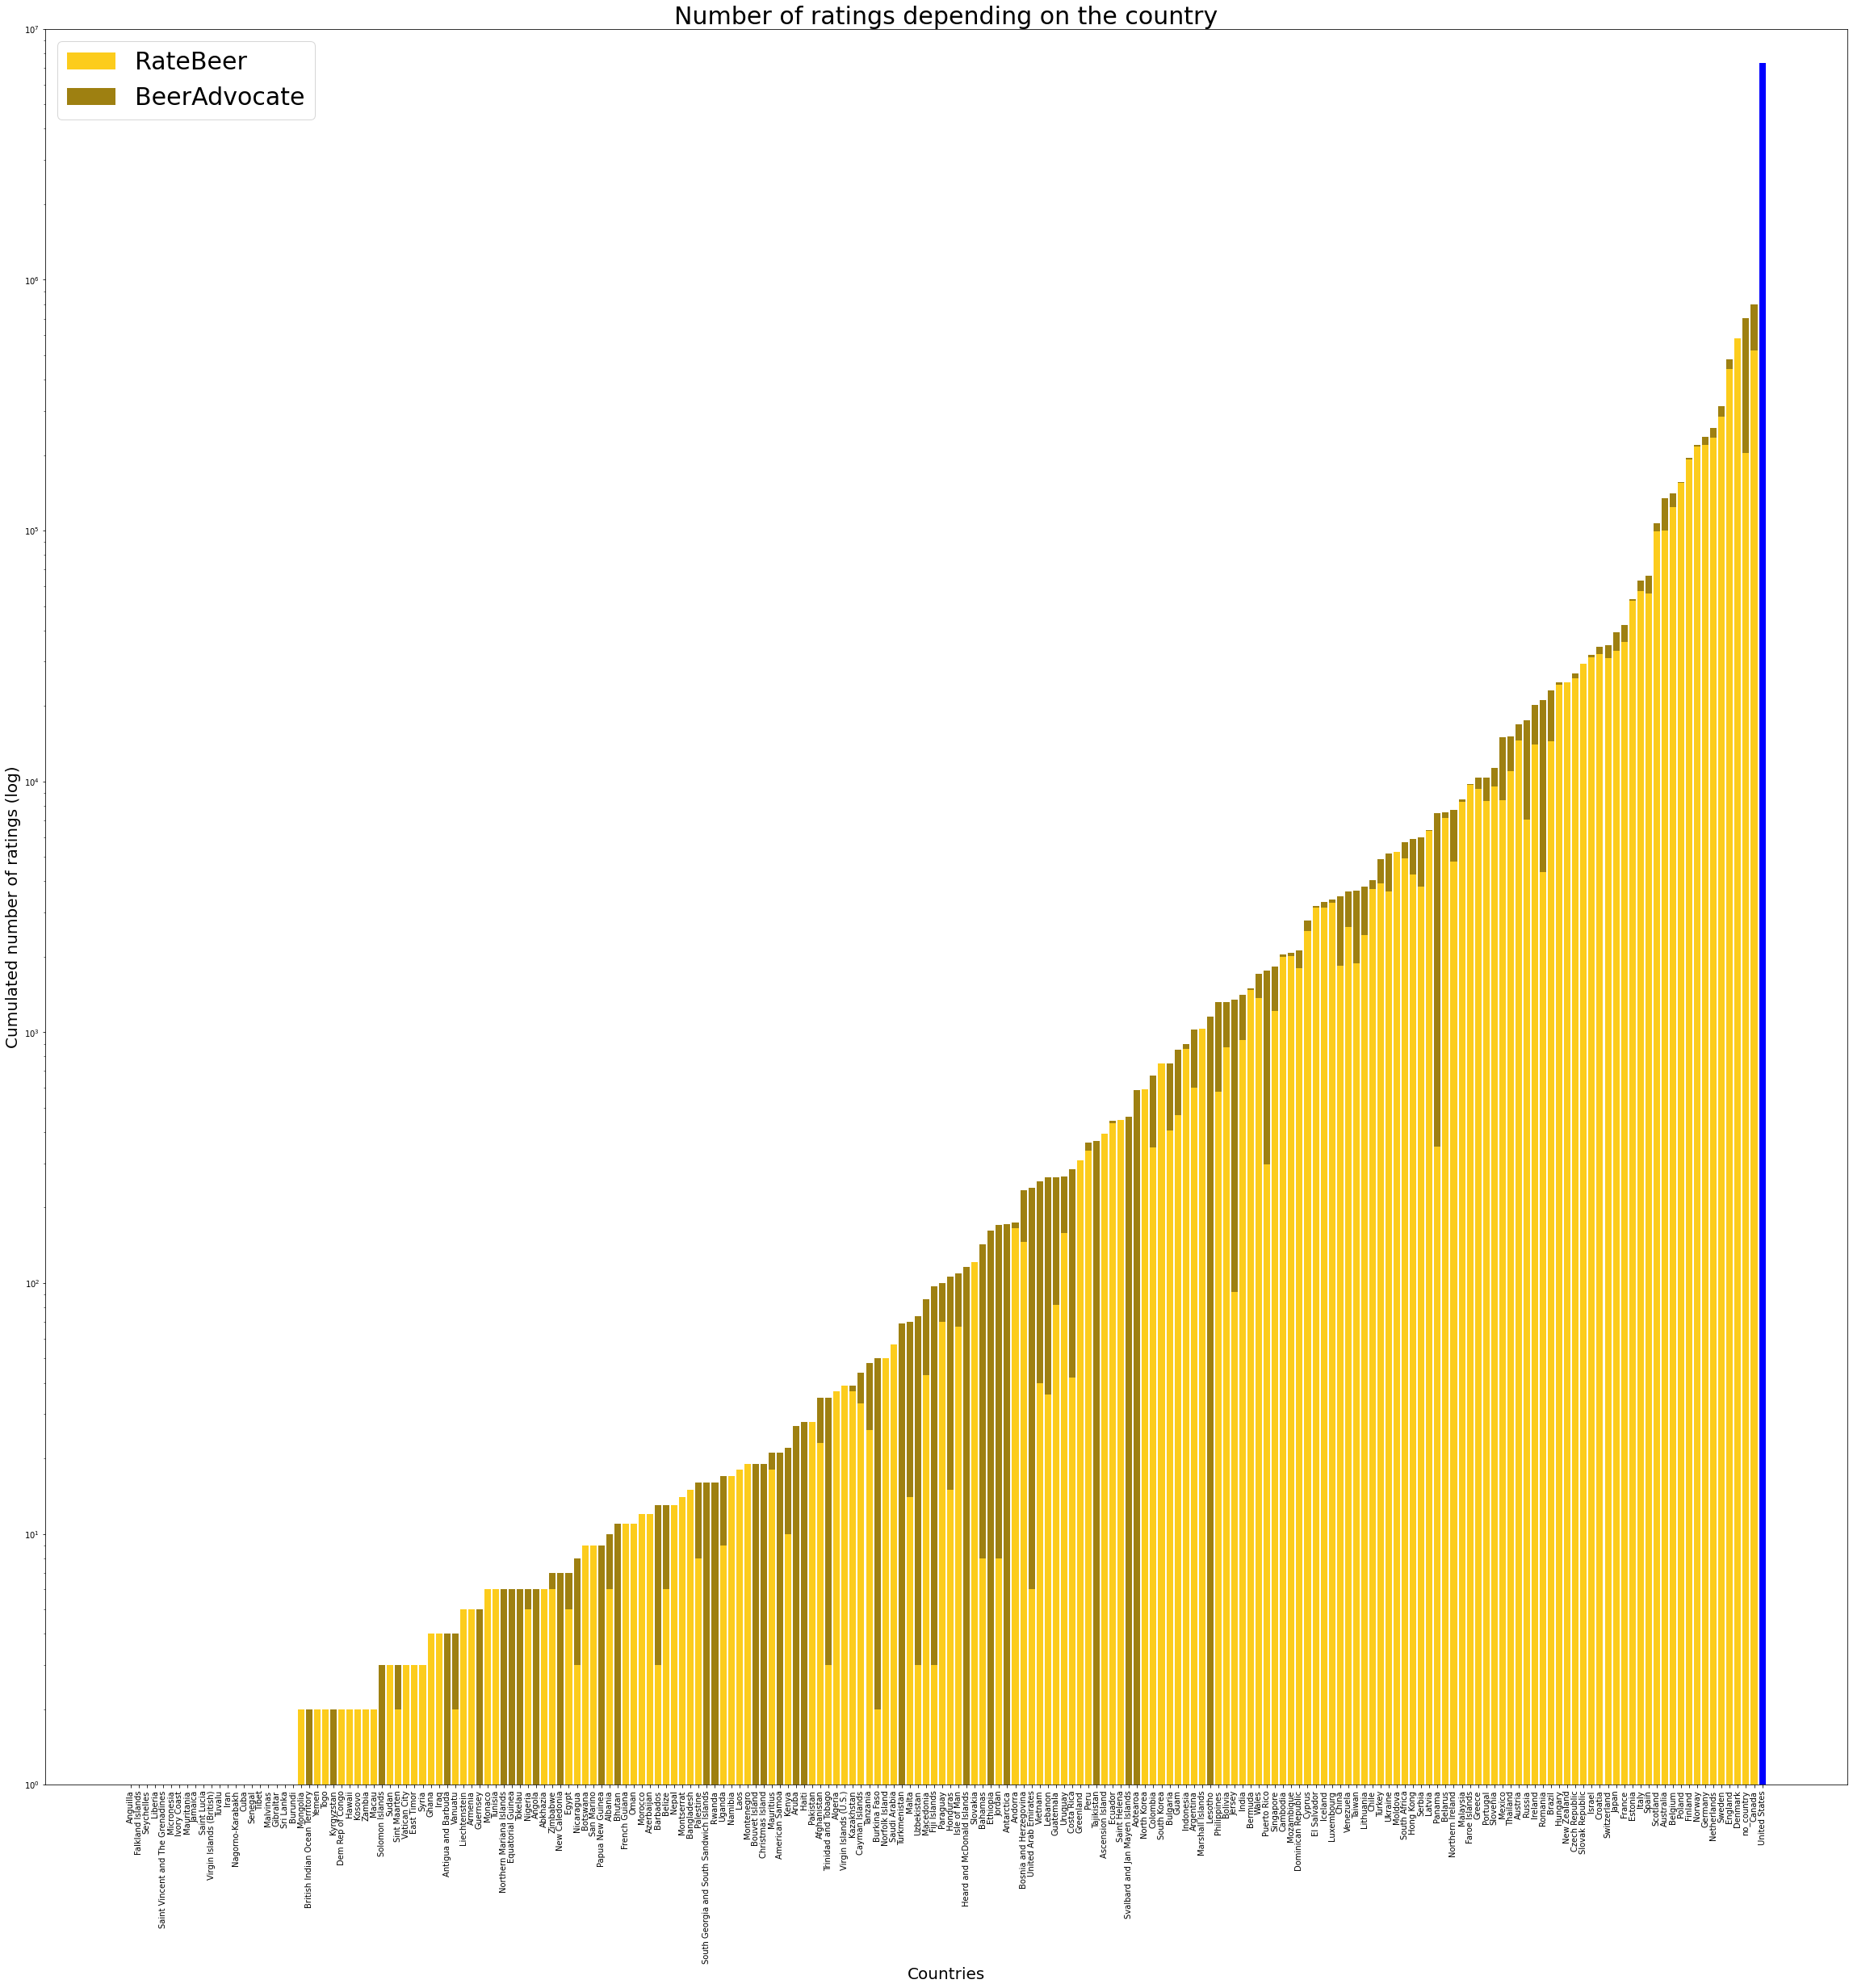

In [27]:
# Plot the distribution
plt.figure(figsize=(40, 40))

# RateBeer
plt.bar(sorted_countries, sorted_nbr_ratings_rb, label='RateBeer', color=rb_color)
plt.bar('United States', nbr_ratings_USagg_rb[-1], color='blue')

# BeerAdvocate
plt.bar(sorted_countries, sorted_nbr_ratings_ba, label='BeerAdvocate', color=ba_color, bottom=sorted_nbr_ratings_rb)
plt.bar('United States', nbr_ratings_USagg_ba[-1], color='blue')

# Legends
plt.yscale('log')
plt.ylim([1,10000000])
plt.xticks(rotation='vertical')
plt.legend(prop={'size':30})
plt.xlabel("Countries", size=20)
plt.ylabel("Cumulated number of ratings (log)", size=20)
plt.title("Number of ratings depending on the country", size=30)
plt.show()

On the above figure we plotted the **number of ratings posted in US in blue** and the number of ratings for all the other countries in yellow. The **y-axis** is in **logarithmic scale**.

We can see that the total number of rating from the US is much higher than in the other countries. There are nearly **10 millions ratings from the US whereas the second country (Canada) only has 1 million**.

💡 **Conclusion** 

Given the number of comments we have from the United States, we therefore advise our client to open his brewery in the United States. <br> Indeed, knowing that our client wants to **build its business and market intelligence on the study of consumer comments**, the analysis will be much more relevant in the United States and our client will be able to get real benefits from our work. 

### **Evolution of the beer industry over the past few years**

We need to understand how the current beer market behaves in US to be able to know if opening a brewery is a strategic choice for our client. <br> 
To do this, we will determine *how many breweries have opened the past few years* and *of which kind they are*. 

#### **Evolution of the number of breweries involved in the ratings per year**

In [28]:
#Retrieve the rows related to United States

#List of states from US
countries_US_ba = [i for i in countries_ba if i.startswith('United States')]
countries_US_rb = [i for i in countries_rb if i.startswith('United States')]

#Filter breweries datasets
breweries_ba = breweries_ba[breweries_ba['location'].isin(countries_US_ba)]
breweries_rb = breweries_rb[breweries_rb['location'].isin(countries_US_rb)]

#Filter beers datasets
beers_ba = beers_ba[beers_ba['location'].isin(countries_US_ba)]
beers_rb = beers_rb[beers_rb['location'].isin(countries_US_rb)]

In [29]:
print(breweries_ba.shape[0], ' american breweries are registred on Beer Advocate')
print(breweries_rb.shape[0], ' american breweries are registred on Rate Beer')

7398  american breweries are registred on Beer Advocate
6907  american breweries are registred on Rate Beer


In [30]:
def evolution_nb_breweries(df) :
  #Create a dict : key = year / value = set of breweries which have at least one rating at this date
  ratings_year = dict()

  for index, row in df.iterrows() :
      brewery_id = row['brewery_id']
      for date in row['dates'] :
        if date.year not in ratings_year :
          ratings_year[date.year] = {brewery_id}
        else : 
          ratings_year[date.year].add(brewery_id)

  #Create a DataFrame which contains the number of breweries involved in the ratings per year
  years = []
  nb_breweries = []
  for key, value in ratings_year.items() :
    years.append(key)
    nb_breweries.append(len(value))

  years_nb_breweries = pd.DataFrame({'year' : years, 'nb_breweries' : nb_breweries})
  years_nb_breweries.sort_values('year', ascending=True, inplace = True)

  return years_nb_breweries


In [31]:
years_nb_breweries_rb = evolution_nb_breweries(beers_rb)
years_nb_breweries_ba = evolution_nb_breweries(beers_ba)

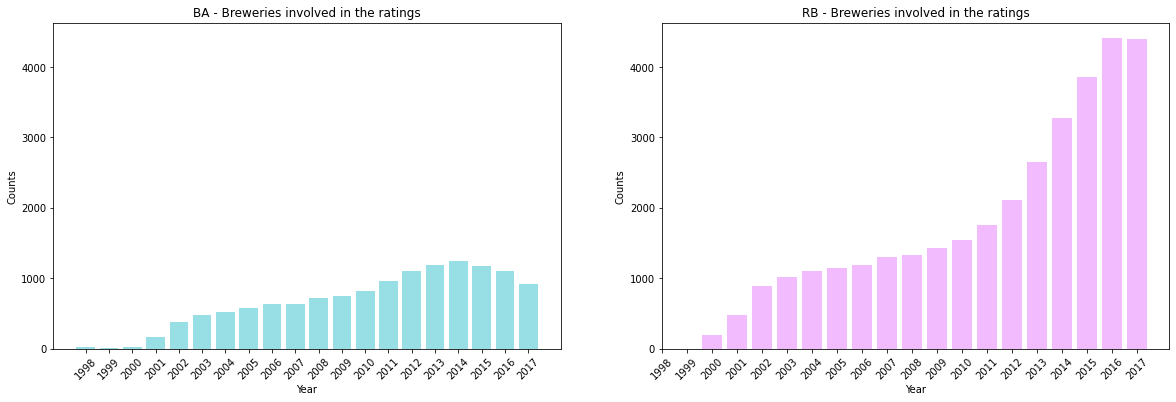

In [32]:
fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)

ax1.bar(x=years_nb_breweries_ba.year.values, height = years_nb_breweries_ba.nb_breweries.values, width=0.8, bottom=None, align='center',  color = blue, alpha=0.8)
ax1.set_xlabel('Year')
ax1.set_ylabel('Counts')
ax1.set_title('BA - Breweries involved in the ratings')
ax1.set_xticks(ticks = years_nb_breweries_ba.year.values)
plt.setp(ax1.get_xticklabels(), rotation=45)

ax2.bar(x=years_nb_breweries_rb.year.values, height = years_nb_breweries_rb.nb_breweries.values, width=0.8, bottom=None, align='center',  color = purple, alpha=0.4)
ax2.set_xlabel('Year')
ax2.set_ylabel('Counts')
ax2.set_title('RB - Breweries involved in the ratings')
ax2.set_xticks(ticks = years_nb_breweries_ba.year.values)
plt.setp(ax2.get_xticklabels(), rotation=45)

plt.show()

In [33]:
print('BA - Maximum number of breweries (in 2014) : ', years_nb_breweries_ba.nb_breweries.max())
print('RB - Maximum number of breweries (in 2016) : ', years_nb_breweries_rb.nb_breweries.max())

BA - Maximum number of breweries (in 2014) :  1249
RB - Maximum number of breweries (in 2016) :  4410


In [34]:
print('Date of the last rating on Rate Beer :', max(ratings_overview_rb.dates.values))

Date of the last rating on Rate Beer : 2017-07-31T10:00:00.000000000


💡**Conclusion**

The number of breweries involved in ratings has been growing very quickly over the past decade in the United States. 
Indeed, we can see on Rate Beer that this evolution even follows an exponential trend since 2007. We don't need to worry about the stabilization in 2017 because the ratings we have available stop in July 2017. 

In **only 10 years**, the number of breweries involved in the ratings has increased **from $1304$ in 2006 to $4410$ in 2016**, which corresponds to a growth of $238\% = \frac{4410 - 1304}{1304} * 100 $.

<br>Regarding **Beer Advocate**, there are **fewer breweries** involved in the ratings. We observe a peak in 2014 corresponding to about 1200 breweries, which matches the number of breweries in 2007 on Rate Beer before the explosion started. In addition, the curve does not follow the same trend as Rate Beer and the number of breweries is decreasing since 2014. 

Knowing that we want to study the **competition on the beer market**, focusing on the **Rate Beer** review site seems to be more relevant to study our client's **potential competitors**.


#### **Evolution of the number of ratings per year**

The **evolution of the number of breweries** involved in the ratings might **depend** strongly on the **number of ratings** on the site, which could explain why the curve for Beer Advocate does not follow the same trend as the curve for Rate Beer.
<br><br> Hence, we will study the evolution of the number of ratings for the two websites only for beers produced by American breweries.

In [35]:
#Get the location of the brewery and add it to the ratings_overview dataset
beers_ba_tmp = beers_ba[['beer_id', 'brewery_id', 'location']]
ratings_overview_ba_tmp = pd.merge(ratings_overview_ba, beers_ba_tmp, how='inner', on='beer_id')

beers_rb_tmp = beers_rb[['beer_id', 'brewery_id', 'location']]
ratings_overview_rb_tmp = pd.merge(ratings_overview_rb, beers_rb_tmp, how='inner', on='beer_id')

#Keep only the ratings produced by american breweries
ratings_overview_ba = ratings_overview_ba_tmp[ratings_overview_ba_tmp['location'].isin(countries_US_ba)]
ratings_overview_rb = ratings_overview_rb_tmp[ratings_overview_rb_tmp['location'].isin(countries_US_rb)]

#Store the year of the rating
ratings_overview_ba['year'] = ratings_overview_ba.dates.apply(lambda x : x.year)
ratings_overview_rb['year'] = ratings_overview_rb.dates.apply(lambda x : x.year)

#Group the ratings by year
ratings_per_year_ba = ratings_overview_ba.groupby('year').beer_id.count()
ratings_per_year_rb = ratings_overview_rb.groupby('year').beer_id.count()


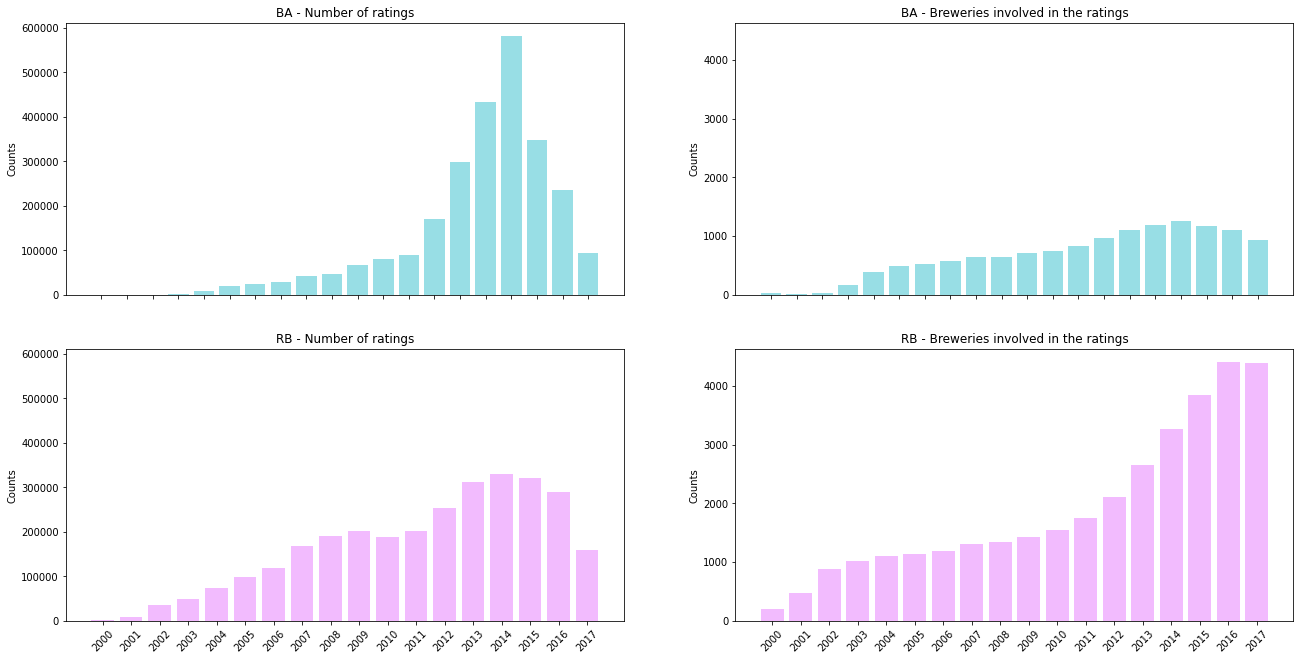

In [36]:
#Plot the evolution of the number of ratings
fig = plt.figure(figsize = (22, 11))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3, sharey=ax1)
ax4 = fig.add_subplot(2, 2, 4, sharey=ax2)

ax1.bar(x=ratings_per_year_ba.index, height = ratings_per_year_ba.values, width=0.8, bottom=None, align='center', color=blue, alpha=0.8)
ax1.set_ylabel('Counts')
ax1.set_title('BA - Number of ratings')
ax1.set_xticks(ticks = years_nb_breweries_ba.year.values)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2.bar(x=years_nb_breweries_ba.year.values, height = years_nb_breweries_ba.nb_breweries.values, width=0.8, bottom=None, align='center',  color = blue, alpha=0.8)
ax2.set_ylabel('Counts')
ax2.set_title('BA - Breweries involved in the ratings')
ax2.set_xticks(ticks = years_nb_breweries_ba.year.values)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3.bar(x=ratings_per_year_rb.index, height = ratings_per_year_rb.values, width=0.8, bottom=None, align='center', color=purple, alpha=0.4)
ax3.set_ylabel('Counts')
ax3.set_title('RB - Number of ratings')
ax3.set_xticks(ticks = years_nb_breweries_rb.year.values)
plt.setp(ax3.get_xticklabels(), rotation=45)

ax4.bar(x=years_nb_breweries_rb.year.values, height = years_nb_breweries_rb.nb_breweries.values, width=0.8, bottom=None, align='center',  color = purple, alpha=0.4)
ax4.set_ylabel('Counts')
ax4.set_title('RB - Breweries involved in the ratings')
ax4.set_xticks(ticks = years_nb_breweries_rb.year.values)
plt.setp(ax4.get_xticklabels(), rotation=45)

plt.show()


In [37]:
print('RB : ', stats.pearsonr(ratings_per_year_rb.values, years_nb_breweries_rb.nb_breweries.values))
print('BA : ', stats.pearsonr(ratings_per_year_ba.values, years_nb_breweries_ba.nb_breweries.values))


RB :  (0.7645778777533397, 0.00021965042116059262)
BA :  (0.8178640658462963, 1.0592513676197868e-05)


We can indeed see that the **number of ratings on Beer Advocate drops drastically from 2015**, while it decreases minimally on Rate Beer (taking into account that ratings stop in July 2017). 

Moreover, the **Pearson coefficients** show actually a **strong linear relationship** (~ $0.76$ for RB and ~ $0.82$ for BA) between the two distributions which is **very significant** (p-value ~ $0.0002$ for RB and ~ $10^{-5}$ for BA).

This **drop** in the **number of comments** on Beer Advocate may explain why the **number of breweries** involved in the ratings **decreases** from 2015. 


Let's now compare the evolution of ratings on the two websites by plotting them on the same plot. 


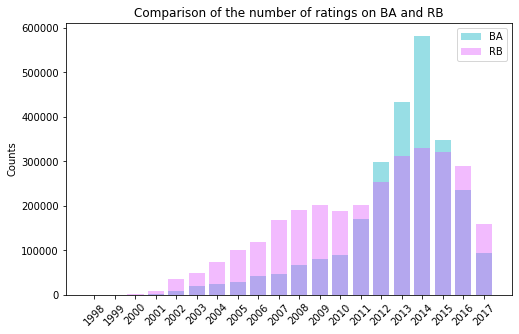

In [38]:
plt.figure(figsize= (8, 5))
plt.bar(x=ratings_per_year_ba.index, height = ratings_per_year_ba.values, width=0.8, bottom=None, align='center', color=blue, alpha=0.8, label = 'BA')
plt.bar(x=ratings_per_year_rb.index, height = ratings_per_year_rb.values, width=0.8, bottom=None, align='center', color=purple, alpha=0.4, label = 'RB')

plt.ylabel('Counts')
plt.title('Comparison of the number of ratings on BA and RB')
plt.xticks(ticks = years_nb_breweries_ba.year.values, rotation=45)
plt.legend()
plt.show()

We can see a **peak** in the number of ratings **between 2010 and 2016** for the two websites, with the **maximum** values reached in **2014**. 

Moreover, **Beer Advocate** gets a **higher** number of ratings **between 2012 and 2015** whereas Rate Beer was always above outside these dates. 

Hence, **Beer Advocate** reached a **high peak in popularity in 2013/2014** with a number of ratings almost equals to **582 242** (so **6 times higher** than in 2014 - 88 398 ratings), but since then, the number of ratings is higher on Rate Beer. 





#### **Evolution of consumers behavior**

Let's check ***how consumers behave on both websites*** to understand why we get this spike in ratings and why Beer Advocate got a higher number of ratings between 2012 and 2015. 

For that, we will split the ratings into 3 periods: 

*   **Between 2007 and 2011** when Rate Beer got highest number of ratings
*   **Between 2012 and 2015** when Beer Advocate was on top 
*   **After 2015** when Rate Beer returns to first place

In [39]:
#Extract the year of ratings
ratings_overview_ba['year'] = ratings_overview_ba.dates.apply(lambda x : x.year)
ratings_overview_rb['year'] = ratings_overview_rb.dates.apply(lambda x : x.year)

#----- Keep the ratings from 2007 to 2011 -----
#Count how many different users made at least one rating
ratings_overview_ba_before = ratings_overview_ba[(ratings_overview_ba['dates'] < np.datetime64('2012-01-01')) & (ratings_overview_ba['dates'] >= np.datetime64('2007-01-01'))]
ratings_overview_rb_before = ratings_overview_rb[(ratings_overview_rb['dates'] < np.datetime64('2012-01-01')) & (ratings_overview_rb['dates'] >= np.datetime64('2007-01-01'))]

#----- Keep the ratings from 2012 to 2015 -----
ratings_overview_ba_during = ratings_overview_ba[(ratings_overview_ba['dates'] < np.datetime64('2016-01-01')) & (ratings_overview_ba['dates'] >= np.datetime64('2012-01-01'))]
ratings_overview_rb_during = ratings_overview_rb[(ratings_overview_rb['dates'] < np.datetime64('2016-01-01')) & (ratings_overview_ba['dates'] >= np.datetime64('2012-01-01'))]

# ----- Keep the ratings from 2016 to 2017 ----
ratings_overview_ba_after = ratings_overview_ba[(ratings_overview_ba['dates'] >= np.datetime64('2016-01-01'))]
ratings_overview_rb_after = ratings_overview_rb[(ratings_overview_rb['dates'] >= np.datetime64('2015-01-01'))]


In [40]:
#Basic statistics on the number of ratings made by one user during one year
res_ba = ratings_overview_ba_before.groupby(['user_ids', 'year']).beer_id.count().describe()
res_rb = ratings_overview_rb_before.groupby(['user_ids', 'year']).beer_id.count().describe()

res2_ba = ratings_overview_ba_during.groupby(['user_ids', 'year']).beer_id.count().describe()
res2_rb = ratings_overview_rb_during.groupby(['user_ids', 'year']).beer_id.count().describe()

res3_ba = ratings_overview_ba_after.groupby(['user_ids', 'year']).beer_id.count().describe()
res3_rb = ratings_overview_rb_after.groupby(['user_ids', 'year']).beer_id.count().describe()

res = pd.DataFrame({'BA - before' : res_ba.values, 'BA - during' : res2_ba.values, 'BA - after' : res3_ba.values,
                    'RB - before' : res_rb.values, 'RB - during' : res2_rb.values, 'RB - after' : res3_rb.values})
res.set_index(res_ba.index, inplace = True)
res

,BA - before,BA - during,BA - after,RB - before,RB - during,RB - after
count,32003.000000,107713.000000,25040.000000,24209.000000,61629.000000,17862.000000
mean,14.113739,15.443688,13.073403,39.183857,27.453098,43.168346
std,30.008880,36.165345,28.795036,97.489078,74.307714,143.653559
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,3.000000,3.000000,5.000000,4.000000,3.000000
75%,13.000000,13.000000,12.000000,28.000000,18.000000,20.000000
max,853.000000,1463.000000,824.000000,2974.000000,2324.000000,4527.000000


We have aggregated in the DataFrame above **descriptive statistics** of the **number of comments made by each user over a year** during the 3 periods. 

<br> First, the **number of consumers** is significantly **higher between 2012 and 2015** on both sites: 

* $107 713$ users vs $32 003$ before and $25 040$ after for BA 
* $43 798$ users vs $24 209$ before and $17 862$ after for RB

It is therefore possible that there was **a big hype** in the United States during **between 2012 and 2015** and that many **new consumers **started to test new beers and to give their opinions on sites such as Beer Advocate and Rate Beer. 

<br>Secondly, we can see that outside of the 2012 to 2015 period, **Rate Beer users rate on average many more beers than Beer Advocate users**: 

* on average 14 beers per user per year before and 13 after for BA
* on average 39 beers per user per year before and 43 after for RB

Notice that the average number of beers rated remains stable (around 15) on BA between 2012 and 2015, whereas it has dropped significantly for RB (around 16). That could be explained by the fact that many amateurs have left ratings on RB during that period. 

<br>💡 **Conclusion**

**Rate Beer users** are therefore a **more confirmed public**, which has not changed much over the years. They must be real passionate by beers and do not hesitate to test new ones and give their opinion. 

**Beer Advocate consumers**, on the other hand, correspond more to a **public of amateurs**, who became passionate about beer during a few years (from 2012 to 2015), when the number of ratings exploded on Beer Advocate and overtook Rate Beer. 

Our interpretation, then, would be that many people got into this fad of discovering new beers during this period, but that hype died down pretty quickly and users started rating fewer and fewer beers. 

These consumers caught up in that hype turned more to Beer Advocate, while those with more experience favor Rate Beer for their ratings. 

#### **Do this hype around beers in US had an impact on breweries ?** 

As we have already noticed, the number of ratings in beer revews sites has risen sharply since 2007. We now want to determine *if this beer hype in the US had any positive impact on the brewery business*. As mentioned above, we will base our study on the breweries of **Rate Beer**, knowing that more of them are listed on this site than on Beer Advocate. 

> The number of breweries involved in the reviews has grown very quickly. *Were these breweries already known to users on the beer review sites or did new breweries appear in the ratings ?*

> *Do users adopt a easily new brewery and continue to keep rating it over time after the first rating?* 

To answer these questions, we will compare the **evolution** over the years of the number of : 
- **'in' breweries** that appear for the first time in the ratings 
- **'out' breweries** that no longer appear in the ratings

In [41]:
#For each brewery, we keep the first and last years where they appear in the ratings. 
def first_year_review(x) :
  return min(x).year

def last_year_review(x) :
  return max(x).year

def first_last_years_ratings(beers_US_rb) :
    #Retrieve first and last years of the ratings for each beer
    beers_US_rb['first_year_review'] = beers_US_rb.dates.apply(lambda x : first_year_review(x))
    beers_US_rb['last_year_review'] = beers_US_rb.dates.apply(lambda x : last_year_review(x))

    #Retrieve first and last years of the ratings for each brewery
    first_years = dict()
    last_years = dict()

    for index, row in beers_US_rb.iterrows() : 
      if row['brewery_id'] not in first_years : 
        first_years[row['brewery_id']] = row['first_year_review']

      if row['brewery_id'] in first_years :
        first_years[row['brewery_id']] = min(row['first_year_review'], first_years[row['brewery_id']])
      
      if row['brewery_id'] not in last_years : 
        last_years[row['brewery_id']] = row['last_year_review']
      
      if row['brewery_id'] in last_years :
        last_years[row['brewery_id']] = max(row['last_year_review'], last_years[row['brewery_id']])
    
    #Create a DataFrame with the brewery_id, first and last years of ratings
    first_last_years_df = pd.DataFrame({'brewery_id' : first_years.keys(), 'first_year' : first_years.values(), 'last_year' : last_years.values()})
    first_years_serie = first_last_years_df.groupby('first_year').brewery_id.count()
    last_years_serie = first_last_years_df.groupby('last_year').brewery_id.count()
    first_last_years_count = pd.DataFrame({'year' : first_years_serie.index, 'first_year' : first_years_serie.values, 'last_year' : last_years_serie.values})

    return first_last_years_count, first_last_years_df

In [42]:
first_last_years_count, first_last_years_df = first_last_years_ratings(beers_rb)

In [43]:
#We remove the last year because we don't have all the ratings from 2017
first_last_years_count_to_plot = first_last_years_count.loc[first_last_years_count['year'] < 2017]
years_nb_breweries_rb_to_plot = years_nb_breweries_rb.loc[years_nb_breweries_rb['year'] < 2017]

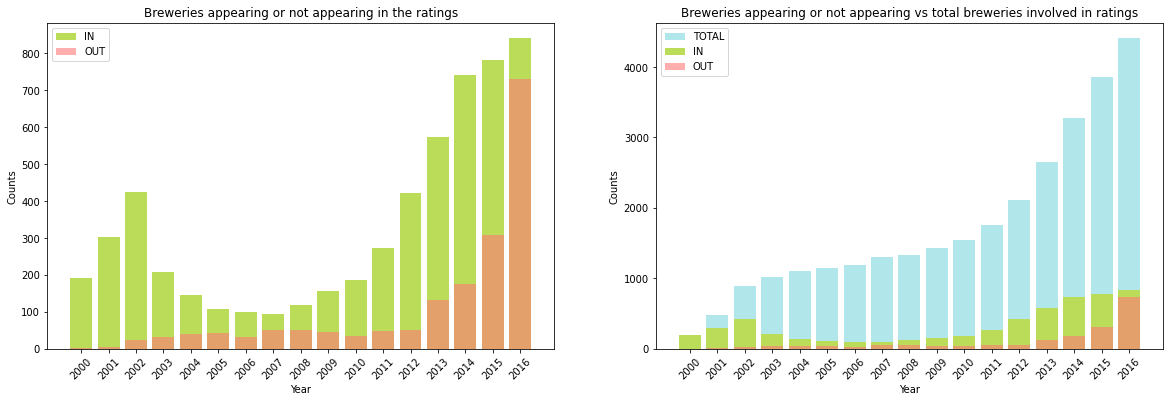

In [44]:
fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.bar(x=first_last_years_count_to_plot.year, height = first_last_years_count_to_plot.first_year, 
        width=0.8, bottom=None, align='center', color=green, alpha=1, label = "IN")
ax1.bar(x=first_last_years_count_to_plot.year, height = first_last_years_count_to_plot.last_year, 
        width=0.8, bottom=None, align='center', color=red, alpha=0.6, label = "OUT")
ax1.set_xlabel('Year')
ax1.set_ylabel('Counts')
ax1.set_title('Breweries appearing or not appearing in the ratings')
ax1.set_xticks(ticks = first_last_years_count_to_plot.year)
ax1.legend()
plt.setp(ax1.get_xticklabels(), rotation=45)

ax2.bar(x=years_nb_breweries_rb_to_plot.year.values, height = years_nb_breweries_rb_to_plot.nb_breweries.values, 
        width=0.8, bottom=None, align='center',  color = blue, alpha=0.6, label = 'TOTAL')
ax2.bar(x=first_last_years_count_to_plot.year, height = first_last_years_count_to_plot.first_year, 
        width=0.8, bottom=None, align='center', color=green, alpha=1, label = "IN")
ax2.bar(x=first_last_years_count_to_plot.year, height = first_last_years_count_to_plot.last_year, 
        width=0.8, bottom=None, align='center', color=red, alpha=0.6, label = "OUT")
ax2.set_xlabel('Year')
ax2.set_ylabel('Counts')
ax2.set_title('Breweries appearing or not appearing vs total breweries involved in ratings')
ax2.set_xticks(ticks = first_last_years_count_to_plot.year)
ax2.legend()
plt.setp(ax2.get_xticklabels(), rotation=45)

plt.show()

In [45]:
print('First year/Last year : ', stats.pearsonr(first_last_years_count.first_year, first_last_years_count.last_year))
print('First year/Total : ', stats.pearsonr(years_nb_breweries_rb.nb_breweries.values, first_last_years_count.first_year))

First year/Last year :  (0.3083572992054753, 0.2131536495653254)
First year/Total :  (0.8342528446747818, 1.6788754595843743e-05)


**The number of 'in' breweries and the number of breweries involved in the ratings** follow the **same trend** over the years. The Pearson coefficient that measures this correlation is very high (~ $0.83$) and significant (p-value ~ $10^{-5}$)


While the number of 'in' breweries remain quite low between 2004 and 2008, it then **explodes** until it **reaches $841$ new breweries** in the ratings in **2016**. 

The quick growth in the number of **'in' breweries** seems to be **strongly related** to the **hype** in the US around beer and the increase in the number of comments starting in 2012. From 2011 to 2014, there are approximately **$150$ new 'in' breweries each year**, which matched well with the spike in the number of ratings we observed earlier. 
> However, we would have to take the analysis further to determine where the causal link is: Did the number of new breweries generate this desire among Americans to discover new beers? Or are people taking advantage of this trend to open breweries? 

**The number of 'out' breweries** remains stable until 2012 and then increases very sharply to 730 'out' breweries in 2016, which is almost the same number as the 'in' breweries that year! which also seems to be related to the hype around beer in the US, and the **strong competition in this field** where hundreds of breweries appear every year. 

*But what are these 'out' breweries? Are they old breweries that have been surpassed by the new 'in' breweries? Or do the new breweries appearing in the comments fail to last?*
To answer this, we will separate the breweries according to the **number of years between the first and the last rating**.



In [46]:
#Retrieve breweries with first rating after 2007 (before the peak in the ratings)
first_last_years_df_after = first_last_years_df[(first_last_years_df['first_year'] >= 2007) & (first_last_years_df['first_year'] < 2017)]

In [47]:
def in_out_diff_years(first_last_years_df_after) : 
  #List with the percentage of breweries, s.t. nb_breweries_in_out[i] contains the percentage of breweries having i years 
  #of difference between 1st and last review
  nb_breweries_in_out = []

  #Dict which stores these values
  breweries_in_out = dict()

  #Check for diff in years between 0 and 10 
  for i in range(11) : 
    #Keep rows where last_year - first_year = i 
    first_last_years1 = first_last_years_df_after.loc[first_last_years_df_after['last_year'] - first_last_years_df_after['first_year'] == i]
    #Retrieve total number of breweries
    nb = first_last_years1.shape[0]
    #Compute percentage
    nb_breweries_in_out.append(100*nb/first_last_years_df.shape[0])
    #Add valeus to list and dict
    breweries_id = first_last_years1.brewery_id.values
    breweries_in_out[str(i)] = breweries_id

  in_out_per_df = pd.DataFrame({'Diff.between first and last review (years)' : [i for i in range(11)], 
                                  'Percentage of breweries' : nb_breweries_in_out})
  in_out_per_df.set_index('Diff.between first and last review (years)')

  return in_out_per_df
  

def avg_nb_rating_per_beers_diff(first_last_years_df_after, ratings_overview_rb) : 
  avg_nb_rating_per_beers = []
  avg_rating_per_beers = []
  for i in range(11) :
    first_last_years1 = first_last_years_df_after.loc[first_last_years_df_after['last_year'] - first_last_years_df_after['first_year'] == i ]
    ratings_diff = ratings_overview_rb.loc[ratings_overview_rb['brewery_id'].isin(first_last_years1.brewery_id.values)]
    avg_nb_ratings_per_beer = ratings_diff.groupby('beer_id').user_ids.count().values
    avg_rating = ratings_diff.rating.mean()
    avg = np.mean(avg_nb_ratings_per_beer)
    avg_nb_rating_per_beers.append(avg)
    avg_rating_per_beers.append(avg_rating)
  return avg_nb_rating_per_beers, avg_rating_per_beers

In [48]:
in_out_per_df = in_out_diff_years(first_last_years_df_after)
avg_nb_rating_per_beers, avg_rating_per_beers = avg_nb_rating_per_beers_diff(first_last_years_df_after, ratings_overview_rb)
in_out_per_df['avg_nb_ratings_per_beer'] = avg_nb_rating_per_beers
in_out_per_df['avg_rating'] = avg_rating_per_beers

print('Percentage of breweries with at least 5 years between first and last ratings : ',
      in_out_per_df.loc[in_out_per_df['Diff.between first and last review (years)'] >= 5]['Percentage of breweries'].sum(), '%\n')
in_out_per_df

Percentage of breweries with at least 5 years between first and last ratings :  16.212292305210518 %



,Diff.between first and last review (years),Percentage of breweries,avg_nb_ratings_per_beer,avg_rating
0,0,6.000968,1.331045,3.222292
1,1,13.969995,2.437302,3.493589
2,2,12.308437,3.127507,3.489144
3,3,10.872721,4.154075,3.506940
4,4,8.162607,6.233131,3.558710
5,5,6.065494,6.911516,3.497691
6,6,3.710276,11.253154,3.560884
7,7,2.387482,20.334900,3.624222
8,8,1.790611,11.686741,3.491978
9,9,1.467979,11.840483,3.473752


In the table above, we have grouped the breweries according to the **difference between the year of the first and last rating**. We also calculated the **average number of comments per beer for each category**, and the **average rate**.

We can see here that **$6$ %** of the breweries **disappear** in the ratings the **same year as the first rating**. Moreover, the **average number of ratings** per beer is almost equal to **$1$**. These breweries have not been able to break through among their competitors. 
>It could be interesting to study the comments on these beers to determine the reason for their failure with consumers. 

We also notice that the **percentage of breweries decreases as the number of years increases**, while the **average number of ratings** per beer **increases**. 
Thus, the new breweries appearing in the ratings do not seem to **persist over time** and it seems **difficult to reach consumers over time**. 

However, when breweries have **succeeded** in establishing themselves in the sector, the **average number of comments increases** as the years go by. It should be noted, however, that the percentage of breweries with more than 5 years between the first and last comment is quite low, around $16.5$ %.

#### ✅ **Conclusion of Part I**

A big hype around beer was born in the United States between 2012 and 2015. The numbers can confirm:
- In **only 10 years**, the number of breweries involved in the ratings has increased **from $1304$ in 2006 to $4410$ in 2016**, which corresponds to a growth of $238\%$. 
- The number of ratings on Rate Beer and Beer Advocate has exploded during this period, which is related to the large number of amateurs who have become interested in beer. 


<br>The number of competitors has grown significantly and **the industry has become very competitive**. Indeed, many breweries did **not manage to federate consumers over time** and more than half of the new breweries on the market have comments on their beers during only 1 year. Our client has to be **very careful not to lose customers after the first year and compete successfully.**

To help our client maximize his chances of success, we will do a **competitive analysis** to know *where our client should locate its brewery* and succeed in outperforming the competition.
We will base this analysis on *Rate Beer* as the number of breweries involved in the reviews is much higher than on Beer Advocate. 


<br>Since the **confirmed audience favors Rate Beer**, we will focus on this site for the analysis of the **characteristics of a beer** that appeal to a real community of experts: what associations of flavors, aromas, palates, etc. in order to best advise our client on the choice of his recipe. 

<br> It can be interesting to **reach the public of amateurs**, because it is a very important market according to what we have seen earlier. For this, we will use **Beer Advocate** to determine the **aspects that create a hype around a beer**: packaging, style, certain flavors in particular? 


## **Part 2 - Competitive analysis**

In this second part, we will determine *who are the potential competitors of our client*. Let's note that our client has given us the following specifications: 
- Passionate about beer, he wants to be as close as possible to his customers and therefore wants to **reach a local clientele** in the state where he will set up his brewery. 
- He is **not able to produce more than 30 beers**. 
- He is **open to all states to set up his brewery**. 

First, we will study the **consumer behavior in each state** to help our client in **choosing the location of his future brewery**. 

Then, we will determine **which competitors will have the same market share** as our client, i.e. local breweries producing no more than 30 beers. 


### **Where should you open your brewery?**

In order to determine ***which states our client should open its brewery in***, we will identify the states where :    

- There is a **large market share to be reached** and a **large number of users** on the review sites
> - Number of *users per state*
> - Number of *breweries per state*
> - *Number of users / Number of breweries*
> - *Evolution* of the *number of users* on the BA and RB sites 

- There are **consumers who like local beers**
> - *Percentage of ratings* of consumers coming from the same state as the brewery
> - *Evolution of the percentage* of ratings for beers produced within the state compared to the total number of ratings in the state 

- There are real **beer fans** who **make a lot of ratings** on the beer review sites and who can be reached by our client's products
> - *Number of ratings / Number of users*
> - *Average of the number of ratings per user*







#### **States with a large market share to reach**


The beer market has exploded in the United States since 2007. Americans are becoming more and more passionate about beer and breweries are opening all the time. 

However, the industry has become very competitive and our client must ***strategically choose where to locate its brewery*** in a state where:     
- There are **beer consumers**, so there is a market share to reach and potential customers
- There is **not much competition**, otherwise it will be difficult to stand out from the other breweries

First, let's determine *where the users of Rate Beer and Beer Advocate come from*. 


##### **Repartition of users and breweries across the states**

In [49]:
#We define some functions we will use for this part
def retrieve_us(df) :
  """Keep only the rows with a location in US""" 
  if 'location' in df.columns : 
    df = df.loc[df['location'].isin(countries_US_rb)]
  elif 'loc_brewery' in df.columns : 
    df = df.loc[df['loc_brewery'].isin(countries_US_rb)]
  elif 'loc_user' in df.columns : 
    df = df.loc[df['loc_user'].isin(countries_US_rb)]

  return df

def state_code(x) :
  """Returns the state code"""
  return us_state_to_abbrev[' '.join(x.split()[2:])]

def add_state_code(df) :
  """Add a column with the state code in a DataFrame"""
  df['state_code'] = df.state.apply(lambda x : state_code(x))
  return df

def plot_map(df, column_to_plot) : 
  """Plot column_to_plot' in a map, df should have a column 'state_code"""
  fig = px.choropleth(df,
                    locations='state_code', 
                    locationmode="USA-states", 
                    scope="usa",
                    color=column_to_plot,
                    color_continuous_scale="Reds", 
                    )
  fig.show()

def top_10(df, column) : 
  return df.sort_values(column, ascending=False).head(10)

def mapping_name_to_index(countries_US_rb) : 
  name_to_index = dict()
  for index, name in enumerate(countries_US_rb) : 
    name_to_index[name] = index
  return name_to_index

In [50]:
#DataFrame which stores the results of our analysis 
#1 for interesting / 2 for very interesting / 0 for neutral / -1 for not interesting 
res_df = pd.DataFrame({'state' : countries_US_rb})
res_df.sort_values('state', inplace=True)
res_df.index = [i for i in range(50)]

#Initialize mapping from name to index row 
countries_US = sorted(countries_US_rb)
name_to_index = mapping_name_to_index(countries_US)

In [51]:
#Retrieve only users from US
users_rb_us = retrieve_us(users_rb)
users_ba_us = retrieve_us(users_ba)
users = pd.concat([users_rb_us, users_ba_us])

#Count the number of users per state
users_by_state = users.groupby('location').user_id.count()
users_by_state_df = pd.DataFrame({'state' : users_by_state.index, 'nb_users' : users_by_state.values})
users_by_state_df = add_state_code(users_by_state_df)

#Plot the number of users per state
plot_map(users_by_state_df, 'nb_users')

The **number of consumers** is **very high** in these states, but the number of breweries in these areas may also be very high, making the market saturated and the industry very competitive. 

So we need to *compare these results to the number of breweries installed in the state*. 

In [52]:
#Retrieve only breweries from US
breweries_rb_us = retrieve_us(breweries_rb)
breweries_ba_us = retrieve_us(breweries_ba)
breweries = pd.concat([breweries_rb_us, breweries_ba_us])

#Count the number of breweries per state
breweries_by_state = breweries.groupby('location').id.count()
breweries_by_state_df = pd.DataFrame({'state' : breweries_by_state.index, 'nb_breweries' : breweries_by_state.values})
breweries_by_state_df = add_state_code(breweries_by_state_df)

#Plot the number of users per state
plot_map(breweries_by_state_df, 'nb_breweries')

In [53]:
top_10_users = top_10(users_by_state_df, 'nb_users')
top_10_breweries = top_10(breweries_by_state_df, 'nb_breweries')
common_users_breweries = top_10_users.merge(top_10_breweries, how='inner', on = 'state' )
common_users_breweries['ratio'] = common_users_breweries['nb_users'] / common_users_breweries['nb_breweries']
common_users_breweries

,state,nb_users,state_code_x,nb_breweries,state_code_y,ratio
0,"United States, California",14442,CA,1796,CA,8.041203
1,"United States, Pennsylvania",10321,PA,626,PA,16.487220
2,"United States, New York",8784,NY,790,NY,11.118987
3,"United States, Illinois",8272,IL,504,IL,16.412698
4,"United States, Texas",7316,TX,518,TX,14.123552
5,"United States, Florida",5873,FL,532,FL,11.039474
6,"United States, Michigan",5354,MI,637,MI,8.405024


As we assumed earlier, the **map** representing the **number of breweries per state** is **similar** to that of the **number of users per state**. 

Of the 10 states with the most users, 7 also have the most breweries. So there could be a **lot of competition** in these states. Indeed, in California and Michigan, there are only 8 customers per brewery, which does not leave much room for newcomers. 

At this stage of the analysis, we do not recommend these states to our client. 


In [54]:
states = top_10_users.loc[~(top_10_users['state'].isin(common_users_breweries.state.values))]
states = states.merge(breweries_by_state_df, how='inner', on='state')
states['ratio'] = states['nb_users'] / states['nb_breweries']
states

,state,nb_users,state_code_x,nb_breweries,state_code_y,ratio
0,"United States, Massachusetts",7332,MA,333,MA,22.018018
1,"United States, Ohio",5934,OH,456,OH,13.013158
2,"United States, New Jersey",4551,NJ,209,NJ,21.775120


The states of **Massachusetts and New Jersey** are more interesting, since the **ratio nb_users/nb_breweries is higher** than in the states of the previous table.

However, for **Ohio**, the **number of breweries is very high** while the **number of users is not in the top 10**. We therefore do not recommend this state. 


In [55]:
#Store the results
res_df['Users & Breweries'] = [0 for i in range(res_df.shape[0])]
res_df.at[name_to_index['United States, Massachusetts'], 'Users & Breweries'] = 1
res_df.at[name_to_index['United States, New Jersey'], 'Users & Breweries'] = 1
res_df.at[name_to_index['United States, Ohio'], 'Users & Breweries'] = -1

for index, row in common_users_breweries.iterrows() : 
  res_df.at[name_to_index[row['state']], 'Users & Breweries'] = -1

From what we have just seen, it may be interesting to *study the ratio nb_users/nb_breweries*.

In [56]:
breweries_users = users_by_state_df.merge(breweries_by_state_df, how='inner', on='state')
breweries_users['ratio'] = breweries_users['nb_users'] / breweries_users['nb_breweries']
breweries_users.sort_values('ratio', ascending=False).head(10)

,state,nb_users,state_code_x,nb_breweries,state_code_y,ratio
38,"United States, Rhode Island",881,RI,40,RI,22.025000
20,"United States, Massachusetts",7332,MA,333,MA,22.018018
29,"United States, New Jersey",4551,NJ,209,NJ,21.775120
0,"United States, Alabama",1847,AL,87,AL,21.229885
9,"United States, Georgia",3358,GA,176,GA,19.079545
6,"United States, Connecticut",3078,CT,177,CT,17.389831
37,"United States, Pennsylvania",10321,PA,626,PA,16.487220
12,"United States, Illinois",8272,IL,504,IL,16.412698
19,"United States, Maryland",2867,MD,202,MD,14.193069
35,"United States, Oklahoma",949,OK,67,OK,14.164179


Although the ratio is high in these states, some of them do not have many users (Rhode Island, Alabama) and our client may not find a suitable customer base for its products. 

However, it might be interesting to ***study the evolution of the number of users over the last few years*** to determine **if the demand could increase in the coming years**. Our client would then gain a large market share and become a leader in states where few breweries are still established. 

##### **Evolution of the number of users over the years**

In [57]:
#Merge the location of users to the ratings 

#Only keep the users from USA and the columns user_id/location from this dataframe
users_rb_US = retrieve_us(users_rb)[['user_id', 'location']]
users_ba_US = retrieve_us(users_ba)[['user_id', 'location']]
users_from_US = pd.concat([users_rb_US, users_ba_US])

#Rename the column user_ids and location from ratings 
ratings_overview_rb.rename(columns = {'user_ids' : 'user_id', 'location' : 'loc_brewery'}, inplace=True)
ratings_overview_ba.rename(columns = {'user_ids' : 'user_id', 'location' : 'loc_brewery'}, inplace=True)

#Rename the column location from ratings 
users_rb_US.rename(columns = {'location' : 'loc_user'}, inplace=True)
users_ba_US.rename(columns = {'location' : 'loc_user'}, inplace=True)

#Merge ratings and users to get the location of the user
ratings_rb_from_US = ratings_overview_rb.merge(users_rb_US, how='inner', on='user_id')
ratings_ba_from_US = ratings_overview_ba.merge(users_rb_US, how='inner', on='user_id')
ratings_from_US = pd.concat([ratings_rb_from_US, ratings_ba_from_US])

In [58]:
#For each year, we count the number of ratings per state
count_users_list = []

#For each year
for year in range(2007, 2017) :
  #Keep only the local ratings for that year 
  df_tmp = ratings_from_US.loc[ratings_from_US['year']==year]
    
  #Group by the state and retrieve the number of local ratings for this year
  count_user_year = df_tmp.groupby('loc_user').beer_id.count()
  count_user_year = count_user_year.to_dict()

  #Make all the dictionaries of the same length
  for state in countries_US : 
    if state not in count_user_year.keys() : 
      count_user_year[state] = 0 
    if state not in count_user_year.keys() : 
      count_user_year[state] = 0 

  count_users_list.append(count_user_year)

def create_df_counts_per_state(df) : 
  """Create a DataFrame from a list of dict"""
  df = pd.DataFrame.from_dict(df)
  df['year'] = [i for i in range(2007, 2017)]
  df.set_index('year', inplace=True)
  df = df.T
  df = df.fillna(0)
  return df

In [59]:
#Create the dataframes
counts_users_df = create_df_counts_per_state(count_users_list).sort_index()
#Statistics of the last year with full ratings
print(counts_users_df[2016].describe())

count       50.000000
mean      4125.040000
std       4398.616317
min         22.000000
25%        772.250000
50%       3047.000000
75%       6058.750000
max      18996.000000
Name: 2016, dtype: float64


In [60]:
counts_users_df2 = counts_users_df.loc[counts_users_df[2016] >= counts_users_df[2016].quantile(0.5)].sort_values(2016, ascending = False)

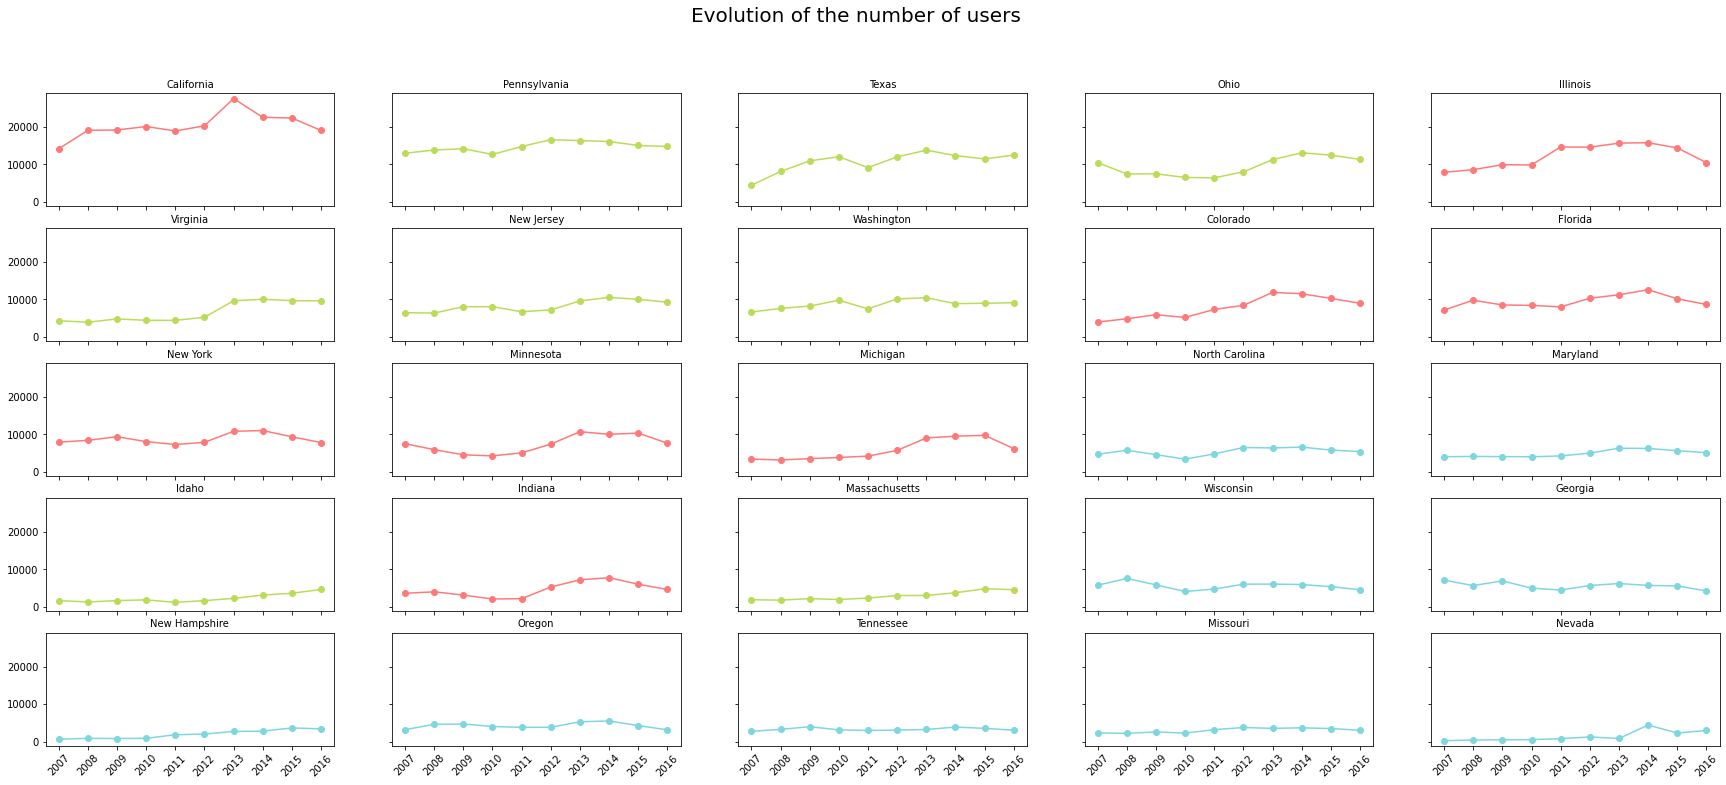

In [61]:
fig, axs = plt.subplots(5, 5, figsize=(30,12), sharex=True, sharey=True)
fig.suptitle('Evolution of the number of users', fontsize=20)

for i, state in enumerate(counts_users_df2.index):
    # Get the info on the plot
    row = i // 5
    col = i % 5
    subplot = axs[row, col]
    
    # Get the list of points
    state_info = counts_users_df2.iloc[i].values

    #Set the label 
    label = ' '.join(state.split()[2:])

    # Plot the percentage of breweries rated 
    if label in ['California', 'Illinois', 'New York', 'Colorado', 'Florida', 'New York', 'Minnesota', 'Michigan', 'Indiana'] : 
      subplot.plot(counts_users_df2.columns, state_info, color=red, marker = 'o')
    elif label in ['Pennsylvania', 'Texas', 'Virginia', 'New Jersey', 'Washington', 'Idaho', 'Massachusetts', 'Ohio'] : 
      subplot.plot(counts_users_df2.columns, state_info, color=green, marker = 'o')
    else : 
      subplot.plot(counts_users_df2.columns, state_info, color=blue, marker = 'o')

    subplot.set_xticks([i for i in range(2007, 2017)])
    plt.setp(subplot.get_xticklabels(), rotation=45)
    subplot.set_title(label, fontsize=10)


plt.show()

We can see here that some states have seen their number of users increasing over the last few years or stabilizing, which signifies a recent and growing craze in the states. Texas, Ohio, Virginia and Idaho are the 4 states with the best evolution in the last years. The population of these states could therefore represent a potential target for our client. 

Other states, however, have seen their number of users drop in recent years. California and Illinois are among the states with the most consumers and the most breweries. We strongly advise against these states because it seems that there was a big hype around beer in the last few years but that this fervor is decreasing. 

In [62]:
res_df['Evolution users'] = [0 for i in range(res_df.shape[0])]
for name in ['Texas', 'Ohio', 'Virginia', 'Idaho'] :
  res_df.at[name_to_index['United States, ' + name], 'Evolution users'] = 2

for name in ['Pennsylvania', 'New Jersey', 'Washington', 'Massachusetts'] : 
  res_df.at[name_to_index['United States, ' + name], 'Evolution users'] = 1

for name in ['New York', 'Colorado', 'Florida', 'New York', 'Minnesota', 'Michigan', 'Indiana'] :
  res_df.at[name_to_index['United States, ' + name], 'Evolution users'] = -1

for name in ['California', 'Illinois'] :
  res_df.at[name_to_index['United States, ' + name], 'Evolution users'] = -2

#### **Where are the local beer lovers?**



Our client wants to **reach a local clientele** in the state where he will set up his brewery, so we are going to determine *which states have a preference for local products*. 

To do this, we will measure for each state the **percentage of ratings related to beers produced in the user's state compared to the total number of ratings in the state**. 

Next, we will determine *which states could potentially contain local beer lovers* by **studying the change in the percentage of local ratings over time.** 

In [63]:
#Merge the location of users to the ratings 

#Only keep the users from USA and the columns user_id/location from this dataframe
users_rb_US = retrieve_us(users_rb)[['user_id', 'location']]
users_ba_US = retrieve_us(users_ba)[['user_id', 'location']]
users_from_US = pd.concat([users_rb_US, users_ba_US])

#Rename the column user_ids and location from ratings 
ratings_overview_rb.rename(columns = {'user_ids' : 'user_id', 'location' : 'loc_brewery'}, inplace=True)
ratings_overview_ba.rename(columns = {'user_ids' : 'user_id', 'location' : 'loc_brewery'}, inplace=True)

#Rename the column location from ratings 
users_rb_US.rename(columns = {'location' : 'loc_user'}, inplace=True)
users_ba_US.rename(columns = {'location' : 'loc_user'}, inplace=True)

#Merge ratings and users to get the location of the user
ratings_rb_from_US = ratings_overview_rb.merge(users_rb_US, how='inner', on='user_id')
ratings_ba_from_US = ratings_overview_ba.merge(users_rb_US, how='inner', on='user_id')
ratings_from_US = pd.concat([ratings_rb_from_US, ratings_ba_from_US])

#Get the rows where the location of the brewery is the same than the location of the user 
local_df = ratings_from_US.loc[ratings_from_US['loc_brewery'] == ratings_from_US['loc_user']]
us_df = ratings_from_US.loc[ (ratings_from_US['loc_brewery'].str.startswith('United States')) & 
                                (ratings_from_US['loc_user'].str.startswith('United States'))]

In [64]:
#For each year, we count the percentage of local ratings comparaing to all the number of comments in the US 
count_local_list = []
count_us_list = []

#For each year
for year in range(2007, 2017) :
  #Keep only the local ratings for that year 
  local_df_tmp = local_df.loc[local_df['year']==year]
    
  #Group by the state and retrieve the number of local ratings for this year
  count_local_year = local_df_tmp.groupby('loc_user').beer_id.count()
  count_local_year = count_local_year.to_dict()

  #Same with ratings from US
  us_df_tmp = us_df.loc[us_df['year']==year]
  count_us_year = us_df_tmp.groupby('loc_user').beer_id.count()
  count_us_year = count_us_year.to_dict()

  #Make all the dictionaries of the same length
  for state in countries_US : 
    if state not in count_local_year.keys() : 
      count_local_year[state] = 0 
    if state not in count_us_year.keys() : 
      count_us_year[state] = 0 

  count_local_list.append(count_local_year)
  count_us_list.append(count_us_year)

def create_df_counts_per_state(df) : 
  """Create a DataFrame from a list of dict"""
  df = pd.DataFrame.from_dict(df)
  df['year'] = [i for i in range(2007, 2017)]
  df.set_index('year', inplace=True)
  df = df.T
  df = df.fillna(0)
  return df

In [65]:
#Create the two dataframes
counts_local_df = create_df_counts_per_state(count_local_list).sort_index()
counts_us_df = create_df_counts_per_state(count_us_list).sort_index()

#Add a column of percentage of local ratings
for year in counts_local_df.columns : 
  name_column = str(year)+('(%)')
  counts_local_df[name_column] = 100*counts_local_df[year] / counts_us_df[year]

#Change nan values to 0
counts_local_df = counts_local_df.fillna(0)

In [66]:
#Statistics of the last year with full ratings
print(counts_local_df['2016(%)'].describe()) 

count    50.000000
mean     26.949997
std      13.591067
min       3.225806
25%      16.570328
50%      27.181222
75%      35.886490
max      59.912613
Name: 2016(%), dtype: float64


The **maximum percentage of reviews for local beers** is equal to $59$% while **half of the states** have a percentage of ratings for local beers **below** $28$%. Therefore, we will not study all of these states and we will keep only the states with a **percentage of local ratings above the median**.

In [67]:
#Keep states whose percentage of ratings greater than the median. 
counts_local_df2 = counts_local_df.loc[counts_local_df['2016(%)'] >= counts_local_df['2016(%)'].median()].sort_values('2016(%)', ascending = False)
counts_local_df2_ev = counts_local_df2.drop(columns = [i for i in range(2007, 2017)])
#Rename columns for plotting
for i in range(2007, 2017) : 
  counts_local_df2_ev = counts_local_df2_ev.rename({ str(i) + '(%)' : str(i)}, axis = 1)

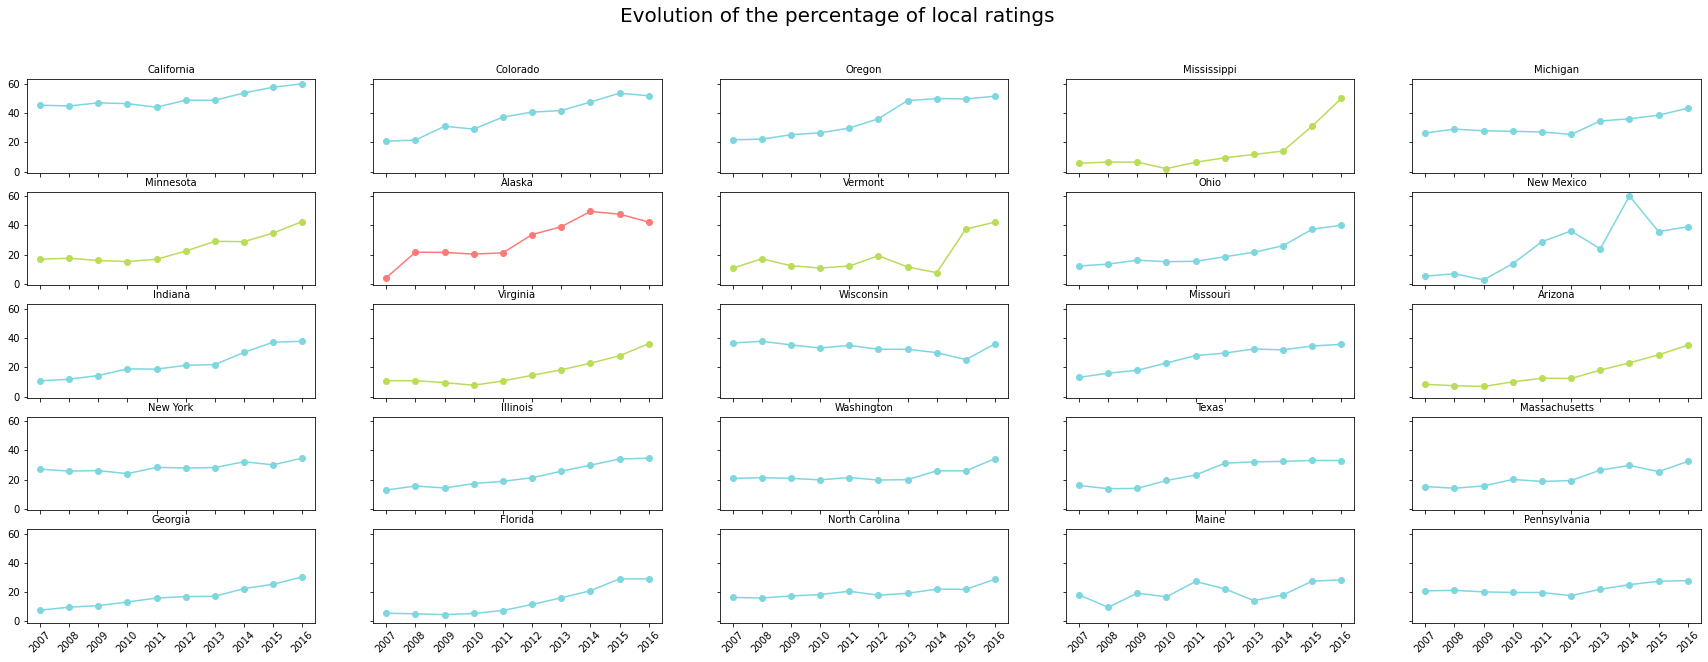

In [68]:
fig, axs = plt.subplots(5, 5, figsize=(30,10), sharex=True, sharey=True)
fig.suptitle('Evolution of the percentage of local ratings', fontsize=20)

for i, state in enumerate(counts_local_df2_ev.index):
    # Get the info on the plot
    row = i // 5
    col = i % 5
    subplot = axs[row, col]
    
    # Get the list of points
    state_info = counts_local_df2_ev.iloc[i].values

    #Set the label 
    label = ' '.join(state.split()[2:])

    # Plot the percentage of breweries rated 
    if label in ['Mississippi', 'Minnesota', 'Vermont', 'Virginia', 'Arizona'] : 
      subplot.plot(counts_local_df2_ev.columns, state_info, color=green, marker = 'o')
    elif label in ['Alaska'] : 
      subplot.plot(counts_local_df2_ev.columns, state_info, color=red, marker = 'o')
    else : 
      subplot.plot(counts_local_df2_ev.columns, state_info, color=blue, marker = 'o')

    plt.setp(subplot.get_xticklabels(), rotation=45)
    subplot.set_title(label, fontsize=10)

plt.show()

We can see here that the **percentage of ratings for local beers is increasing for most of the states**. In fact, **except for Alaska** where the percentage is slightly decreasing since 2014, we can now confirm that **Americans are turning more and more to local**. We therefore strongly support our client's idea to set up a local brewery. 

Some states are particularly catching our attention:     
- The states of **Vermont, Mississippi, Virginia, Massachusetts, Minnesota** with **very rapid growth since 2014** 
- The states of **California, Colorado, Oregon, Michigan, and Ohio** which are growing more slowly but are in the top 10 states with the highest percentage of local ratings in 2016 (between $40$% and $60$%). 
- The remaining states may still represent potential targets for our client.

In [69]:
top_10_local = top_10(counts_local_df, '2016(%)')
top_10_local = top_10_local.drop(columns = [year for year in range(2007,2017)])
top_10_local

year,2007(%),2008(%),2009(%),2010(%),2011(%),2012(%),2013(%),2014(%),2015(%),2016(%)
"United States, California",45.318458,44.781375,46.905061,46.355831,43.966933,48.713763,48.647170,53.680135,57.578069,59.912613
"United States, Colorado",20.782759,21.494182,30.942005,28.995999,37.196033,40.577994,41.645612,47.468080,53.529354,51.751362
"United States, Oregon",21.724660,22.111512,25.151325,26.436504,29.693878,36.071790,48.412846,49.857499,49.601276,51.425943
"United States, Mississippi",5.630027,6.504065,6.451613,2.000000,6.382979,9.395973,11.666667,14.035088,31.067961,50.000000
"United States, Michigan",26.305221,28.998459,27.834766,27.480133,27.014995,25.355040,34.493042,36.055777,38.462327,43.288591
"United States, Minnesota",16.947354,17.627402,16.073753,15.336572,16.953461,22.496976,29.179104,28.930066,34.812881,42.667534
"United States, Alaska",4.347826,21.739130,21.594069,20.436508,21.311475,33.742331,39.108062,49.532710,47.717231,42.340628
"United States, Vermont",10.833333,17.269076,12.488769,10.950081,12.256267,19.361702,11.669129,7.766990,37.547893,42.261529
"United States, Ohio",12.315177,13.630301,16.299443,15.254753,15.540123,18.645963,21.652220,26.160660,37.406664,40.123239
"United States, New Mexico",5.369128,7.011070,2.884615,13.888889,28.934010,36.231884,24.000000,60.154242,35.810811,39.090909


In [70]:
res_df['Percentage local'] = [0 for i in range(res_df.shape[0])]
for name in ['Vermont', 'Mississippi', 'Virginia', 'Massachusetts', 'Minnesota', 'California', 'Colorado', 'Oregon', 'Michigan', 'Ohio'] :
  res_df.at[name_to_index['United States, ' + name], 'Percentage local'] = 2

for name in ['New Mexico', 'Indiana', 'Wisconsin', 'Missouri', 'New York', 'Illinois', 'Washington', 'Texas', 'Massachusetts', 'Georgia', 'Florida', 'North Carolina', 'Maine', 'Pennsylvania'] : 
  res_df.at[name_to_index['United States, ' + name], 'Percentage local'] = 1

for name in ['Alaska'] :
  res_df.at[name_to_index['United States, ' + name], 'Percentage local'] = -1

#### **Where are the real beer fans who make a lot of ratings ?**

In order for our client's brewery to **endure over time**, we advise them to *create a real community around their brewery*. It would therefore be interesting to determine ***which states are home to consumers who are passionate about beer and who are invested in this growing community***. Indeed, these are the users most likely to be interested in our client's offer.

We will therefore determine ***in which states the most active people on beer reviews sites are located***. 

We will base our analysis on **Rate Beer** because it has a higher number of experienced users. We will measure the *ratio number_ratings/number_users per state* and the *average number of ratings per user*.

In [71]:
#Average rating per user 
avg_rating_state = []
#For each state 
for state in countries_US : 
  #Retrieve the ratings from that state 
  ratings_per_state = ratings_rb_from_US.loc[ratings_rb_from_US['loc_user'] == state]
  
  #Group by user id and take the mean 
  ratings_per_state_user = np.mean(ratings_per_state.groupby('user_id').beer_id.count().values)

  avg_rating_state.append(ratings_per_state_user)

In [72]:
#Count the number of ratings per state 
ratings_per_state = ratings_rb_from_US.groupby('loc_user').beer_id.count()
ratings_by_state_df = pd.DataFrame({'state' : ratings_per_state.index, 'nb_ratings' : ratings_per_state.values})
ratings_by_state_df = add_state_code(ratings_by_state_df)

#Add the number of users per state 
ratings_by_state_df['nb_users'] = users_by_state_df.nb_users.values

#Add the ratio nb_ratings/nb_users
ratings_by_state_df['ratio'] = ratings_by_state_df['nb_ratings']/ratings_by_state_df['nb_users']

#Add the mean of ratings per user 
ratings_by_state_df['avg_ratings'] = avg_rating_state
#Plot the number of users per state
plot_map(ratings_by_state_df, 'ratio')

In [73]:
top_10_ratings_per_user = top_10(ratings_by_state_df, 'ratio')
top_10_ratings_per_user

,state,nb_ratings,state_code,nb_users,ratio,avg_ratings
11,"United States, Idaho",30651,ID,400,76.627500,239.460938
27,"United States, Nevada",19779,NV,620,31.901613,156.976190
5,"United States, Colorado",93508,CO,3100,30.163871,132.635461
46,"United States, Washington",111554,WA,3867,28.847686,125.623874
2,"United States, Arizona",49815,AZ,1826,27.280942,110.454545
41,"United States, Tennessee",42048,TN,1645,25.561094,142.054054
43,"United States, Utah",10255,UT,405,25.320988,101.534653
22,"United States, Minnesota",91516,MN,3622,25.266703,126.753463
48,"United States, Wisconsin",75686,WI,3213,23.556178,95.805063
36,"United States, Oregon",49880,OR,2201,22.662426,92.370370


**Idaho**, leading with a **very high ratio** of nb_ratings/nb_users (~ $77$) and an average of 240 ratings per user has only 400 consumers. The number of ratings is lower than in other countries, but it has only 10,000 fewer ratings than Tennessee which has 4 times as many consumers. The few users that there are in this state are therefore **very active** in the beer community.  

We observe the **same phenomenon in Arizona and Tennessee** which have a **high average of ratings per user but few comments**. 


The states of **Colorado, Washington and Minesota**, on the other hand, have a **very active community** with about 93,500, 111,500 and 91,500 ratings respectively. The users seem to be very invested in the community since the average number of ratings is about 132, 125 and 126 ratings/user. 

We therefore recommend these **3 states to our client** whose **beer community seems very strong**. *Idaho, Arizona and Tenneesse could be real potential targets with a beer loving audience*. 

In [74]:
res_df['Ratings per user'] = [0 for i in range(res_df.shape[0])]
for name in ['Washington', 'Colorado', 'Minnesota'] :
  res_df.at[name_to_index['United States, ' + name], 'Ratings per user'] = 2

for name in ['Idaho', 'Arizona', 'Tennessee'] : 
  res_df.at[name_to_index['United States, ' + name], 'Ratings per user'] = 1

In [75]:
total_column = []
for index, row in res_df.iterrows() : 
  total=0
  for column in res_df.columns[1:] : 
    total +=  row[column]
  total_column.append(total)

res_df['Total score'] = total_column

res_part1 = res_df.loc[res_df['Total score'] > 0]
res_part1 = res_part1.sort_values('Total score', ascending = False)
res_part1['state'] = res_part1.state.apply(lambda x : x.split(',')[1])
print(len(res_part1), 'potential states to locate the brewery')

In [76]:
res_part1 = res_df.loc[res_df['Total score'] > 0]
res_part1 = res_part1.sort_values('Total score', ascending = False)
res_part1['state'] = res_part1.state.apply(lambda x : x.split(',')[1])
print(len(res_part1), 'potential states to locate the brewery')

21 potential states to locate the brewery


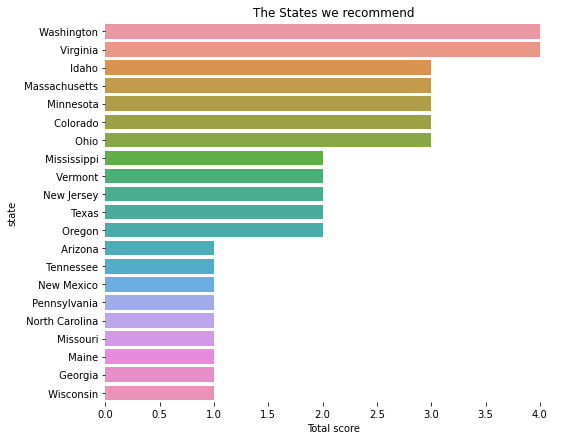

In [78]:
plt.figure(figsize=(8,6))

sns.set_color_codes("pastel")
sns.barplot(x="Total score", y="state", data=res_part1, label="Number of ratings")

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.title('The States we recommend')
plt.show()


### **Which breweries are our client's competitors?**

After investigating user behavior by state in detail, we will now complete our market research by focusing on our client's potential competitors. 

We will filter the breweries according to the following criteria: 
- We remove breweries from the states with a total score of 0 
- We remove the breweries which don't have ratings in 2016/2017
- We keep only the breweries of the same size as our client, new on the market and which will therefore not have the capacity to compete with breweries producing more than 30 beers. 
- We remove the breweries that have a very low number of ratings.

Then, after studying some characteristics of breweries by state, we will select only the states which have caught our attention and we will study in more detail the leading breweries in those states.

Note that we will focus on Rate Beer as the number of breweries is much more important than in Beer Advocate. 


#### **Filter the breweries**

First, we filter breweries to only **keep the ones which could be potential competitors**. 


In [79]:
#First we only keep the breweries which have still some ratings in 2016/2017 
actual_breweries = first_last_years_df.loc[first_last_years_df['last_year'].isin([2016,2017])].brewery_id.values.tolist()
breweries_rb_filtered = breweries_rb.loc[breweries_rb['id'].isin(actual_breweries)]
beers_rb_filtered = beers_rb.loc[beers_rb['brewery_id'].isin(actual_breweries)]
ratings_rb_filtered = ratings_overview_rb.loc[ratings_overview_rb['brewery_id'].isin(actual_breweries)]

print(breweries_rb.shape[0] - breweries_rb_filtered.shape[0], ' breweries out')

1780  breweries out


In [80]:
#Then we remove the breweries from the states which don't have a zero total score 
states_in = res_df.loc[res_df['Total score'] > 0].state.values.tolist()
breweries_rb_filtered2 = breweries_rb_filtered.loc[breweries_rb_filtered['location'].isin(states_in)]

actual_breweries2 = breweries_rb_filtered2.id.values.tolist()

beers_rb_filtered2 = beers_rb_filtered.loc[beers_rb_filtered['brewery_id'].isin(actual_breweries2)]
ratings_rb_filtered2 = ratings_rb_filtered.loc[ratings_rb_filtered['brewery_id'].isin(actual_breweries2)]

print(breweries_rb_filtered.shape[0] - breweries_rb_filtered2.shape[0], ' breweries out')

2376  breweries out


In [81]:
#We filter out breweries with more than 50 beers
breweries_rb_filtered3 = breweries_rb_filtered2.loc[breweries_rb_filtered2['nbr_beers'] <= 30]

actual_breweries3 = breweries_rb_filtered3.id.values.tolist()

ratings_rb_filtered3 = ratings_rb_filtered2.loc[ratings_rb_filtered2['brewery_id'].isin(actual_breweries3)]
beers_rb_filtered3 = beers_rb_filtered2.loc[beers_rb_filtered2['brewery_id'].isin(actual_breweries3)]

print(breweries_rb_filtered2.shape[0] - breweries_rb_filtered3.shape[0], 'breweries out')

1169 breweries out


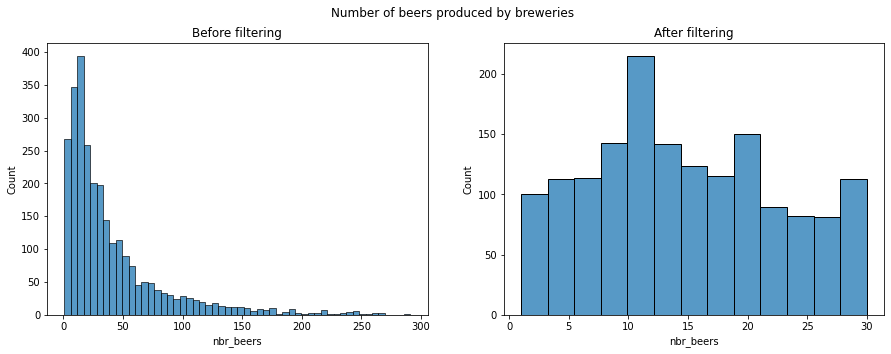

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Number of beers produced by breweries')

# Before
sns.histplot(ax=axes[0], data=breweries_rb_filtered2, x = 'nbr_beers')
axes[0].set_title('Before filtering')

# After
sns.histplot(ax=axes[1], data=breweries_rb_filtered3, x = 'nbr_beers')
axes[1].set_title('After filtering')

plt.show()

In [83]:
#Number of ratings per brewery 
ratings_per_brewery = ratings_rb_filtered3.groupby('brewery_id').beer_id.count()
ratings_per_brewery.describe()

count    1582.000000
mean       71.085335
std       225.439204
min         1.000000
25%         8.000000
50%        23.000000
75%        57.000000
max      6156.000000
Name: beer_id, dtype: float64

**50% of the breweries have only 23 ratings**. These breweries **do not appear to be potential competitors**. Therefore, we will only keep the breweries whose number of ratings is higher than the 75%-quantile, i.e. 57 ratings. 

In [84]:
#List of breweries we are keeping
ratings_per_brewery_df = pd.DataFrame({'id' : ratings_per_brewery.index, 'count' : ratings_per_brewery.values})
actual_breweries4 = ratings_per_brewery_df.loc[ratings_per_brewery_df['count'] >= 57].id.values.tolist()

breweries_rb_filtered4 = breweries_rb_filtered3.loc[breweries_rb_filtered3['id'].isin(actual_breweries4)]
ratings_rb_filtered4 = ratings_rb_filtered3.loc[ratings_rb_filtered3['brewery_id'].isin(actual_breweries4)]
beers_rb_filtered4 = beers_rb_filtered3.loc[beers_rb_filtered3['brewery_id'].isin(actual_breweries4)]

print(breweries_rb_filtered3.shape[0] - breweries_rb_filtered4.shape[0], 'breweries out')

1177 breweries out


In [85]:
print(breweries_rb_filtered4.shape[0], 'potential concurrents')

405 potential concurrents


In [86]:
concurrents_per_state = breweries_rb_filtered4.groupby('location').id.count().values
res_part1['Concurrent breweries'] = concurrents_per_state

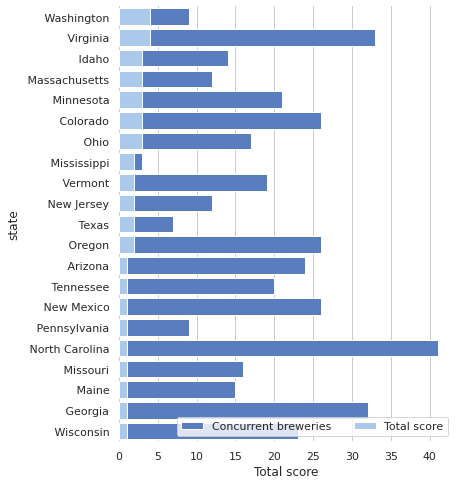

In [87]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 8))

sns.set_color_codes("muted")
sns.barplot(x="Concurrent breweries", y="state", data=res_part1,
            label="Concurrent breweries", color="b")

sns.set_color_codes("pastel")
sns.barplot(x="Total score", y="state", data=res_part1,
            label="Total score", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
sns.despine(left=True, bottom=True)

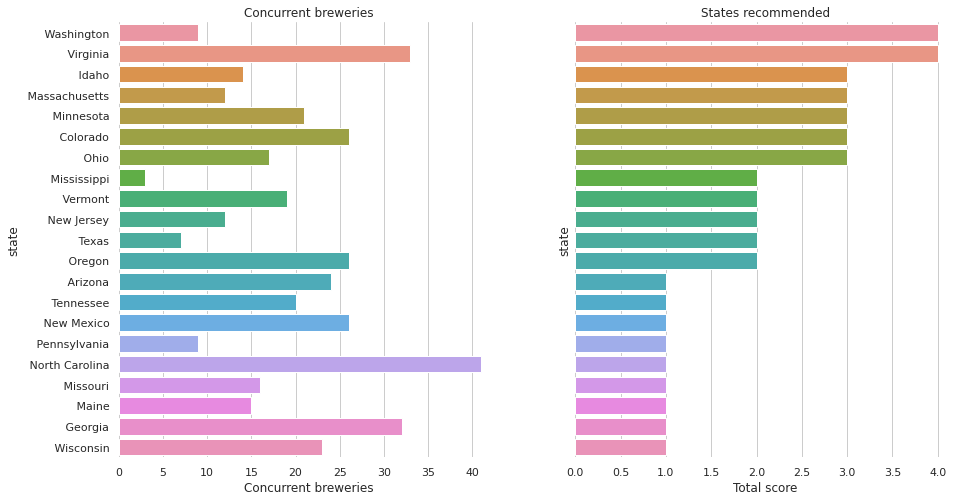

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

# Before
sns.barplot(ax = axes[0], x="Concurrent breweries", y="state", data=res_part1,
            label="Concurrent breweries")
axes[0].set_title('Concurrent breweries')
sns.despine(left=True, bottom=True)

# After
sns.barplot(ax = axes[1], x="Total score", y="state", data=res_part1,
            label="Total score")
axes[1].set_title('States recommended')

plt.show()

The above shows the results of our market research. 
On the left you can see the **number of potential competitors** for our client for each *state whose total score is strictly greater than 0*. 
On the right is the **ranking of the states according to the total score** which corresponds to the *sum of the scores* obtained on the following criteria: 
- **Number of users**: a *high* number of users and therefore a *potential market to reach*
- **Number of users / Number of breweries** : a *low ratio* and therefore a *market not saturated*, with *less competition* 
- **Evolution of the number of users** : a *fast evolution since few years* and a public which is getting more and more interested in beer 
- **Evolution of the percentage of ratings on local beers**: a *fast evolution* and consumers who are more and more attached to the local character. A potential target for our client. 
- **Average number of ratings per user**: a fairly *high number* and therefore a *strong community* of beer lovers who would be interested in our client's products. 



Based on these insights, we are now able to determine the **3 most favorable states for our client's brewery location**. 

**Washington** has the highest total score and the number of competitors is very low. So we choose this state without much hesitation. 

**Virginia** has also the highest score, but there are many competitors in the area. However, we will still choose this state and study in details what kind of beers are offered by the breweries in this territory. The market could in fact be segmented and our client may succeed knowing that a strong community of beer lovers is located in this state

Among the states with a total score equal to 3, we select **Massachussets** beacause of the low number of competitors. 

🏆 **Washington, Virginia, Massachusetts**

####**Leading breweries in the 3 recommended states**

Now that we have chosen 3 potential states where our client could set up his brewery, let's determine w***ho are the potential competitors of our client in each of these states***. To do this, we will use **4 criteria**.  

Which breweries : 

- are the **most popular** with the **highest number of ratings**
- have the **highest average grade** over all the ratings on their beers
- have been established in the area for a long time with the **longest period since the first rating** 
- are the **local breweries** with the **highest percentage of ratings** within the state

##### **Prepare data**

In [89]:
#First we filter datasets to only keep breweries from the 3 recommended states 
states = ['United States, Washington', 'United States, Virginia', 'United States, Massachusetts']

breweries_ids_selected = breweries_rb_filtered4.loc[breweries_rb_filtered4['location'].isin(states)].id.values

breweries_rb_selected = breweries_rb_filtered4.loc[breweries_rb_filtered4['id'].isin(breweries_ids_selected)]
ratings_rb_selected = ratings_rb_filtered4.loc[ratings_rb_filtered4['brewery_id'].isin(breweries_ids_selected)]
beers_rb_selected = beers_rb_filtered4.loc[beers_rb_filtered4['brewery_id'].isin(breweries_ids_selected)]

print(breweries_rb_filtered4.shape[0] - breweries_rb_selected.shape[0], 'breweries out')
print(breweries_rb_selected.shape[0], 'potential concurrents')

332 breweries out
73 potential concurrents


🚨🚨🚨🚨🚨🚨🚨🚨🚨🚨🚨🚨🚨🚨 **The final datasets for the 3 states !!!!**

In [327]:
#Define datasets concerning each of the 3 states
breweries_rb_selected = breweries_rb_selected.rename(columns = {'id' : 'brewery_id'})

#Washington 
breweries_w = breweries_rb_selected.loc[breweries_rb_selected['location'] == 'United States, Washington']
ratings_w = ratings_rb_selected.loc[ratings_rb_selected['loc_brewery'] == 'United States, Washington']
beers_w = beers_rb_selected.loc[beers_rb_selected['location'] == 'United States, Washington']

#Virginia 
breweries_v = breweries_rb_selected.loc[breweries_rb_selected['location'] == 'United States, Virginia']
ratings_v = ratings_rb_selected.loc[ratings_rb_selected['loc_brewery'] == 'United States, Virginia']
beers_v = beers_rb_selected.loc[beers_rb_selected['location'] == 'United States, Virginia']

#Massachusetts
breweries_m = breweries_rb_selected.loc[breweries_rb_selected['location'] == 'United States, Massachusetts']
ratings_m = ratings_rb_selected.loc[ratings_rb_selected['loc_brewery'] == 'United States, Massachusetts']
beers_m = beers_rb_selected.loc[beers_rb_selected['location'] == 'United States, Massachusetts']

In [328]:
def mapping_id_to_index(breweries) : 
  """Create a mapping from brewery_id to row index""" 
  id_to_index = dict()
  cpt = 0
  for index, row in breweries.iterrows() : 
    id_to_index[row['brewery_id']] = cpt 
    cpt += 1
  return id_to_index

id_to_index_w = mapping_id_to_index(breweries_w)
id_to_index_v = mapping_id_to_index(breweries_v)
id_to_index_m = mapping_id_to_index(breweries_m)

In [398]:
def create_res_df(breweries) : 
  """Define a dataframe which will contain the scores of each brewery""" 
  res_breweries = pd.DataFrame({  'name' : breweries.name.values.tolist(), 
                                  'id' : breweries.brewery_id.values.tolist(),
                                  'nb_ratings' : [0 for i in range(breweries.shape[0])],
                                  'avg_ratings' : [0 for i in range(breweries.shape[0])],
                                  'nb_years_since_first_rating' : [0 for i in range(breweries.shape[0])], 
                                  'percentage_local_users': [0 for i in range(breweries.shape[0])]
                                })
  return res_breweries

res_breweries_w = create_res_df(breweries_w)
res_breweries_v = create_res_df(breweries_v)
res_breweries_m = create_res_df(breweries_m)

In [397]:
#Retrieve the results from the previous part
res_part2 = res_part1.iloc[[0,1,3]]

#Add new columns to store scores about concurrent breweries
res_part2['Popular concurrents'] = [0 for i in range(3)]
res_part2['Successfull concurrents'] = [0 for i in range(3)]
res_part2['Old concurrents '] = [0 for i in range(3)]
res_part2['Local concurrents '] = [0 for i in range(3)]

res_part2

,state,Users & Breweries,Evolution users,Percentage local,Ratings per user,Total score,Concurrent breweries,Popular concurrents,Successfull concurrents,Old concurrents,Local concurrents
46,Washington,0,1,1,2,4,9,0,0,0,0
45,Virginia,0,2,2,0,4,33,0,0,0,0
20,Massachusetts,1,1,1,0,3,12,0,0,0,0


##### **Highest number of ratings**

In [366]:
def most_popular_breweries(ratings, breweries) : 
  """Returns a DataFrame containing the 10 breweries with the highest number of ratings"""
  #Count the number of ratings per brewery
  ratings_per_brewery = ratings.groupby('brewery_id').beer_id.count()
  ratings_per_brewery_df = pd.DataFrame({'brewery_id' : ratings_per_brewery.index, 
                                         'nb_ratings' : ratings_per_brewery.values})
  #Keep the columns we are interested in
  breweries_tmp = breweries[['name', 'brewery_id']]

  #Retrieve the name of the brewery
  ratings_per_brewery_df = ratings_per_brewery_df.merge(breweries_tmp, how='inner', on = 'brewery_id')
  
  #Retrieve the breweries with the highest number of ratings
  ratings_per_brewery_df.sort_values('nb_ratings', ascending=False, inplace=True)
  top_10_popular = ratings_per_brewery_df.head(10)

  return top_10_popular

# Creating autocpt arguments
def func(pct, allvalues, kind_plot):
  """For the displaying on the pie chart"""
  if kind_plot == 'i' : 
      absolute = int(pct / 100.*np.sum(allvalues))
      return "{:d}".format(absolute)
  if kind_plot == 'f' : 
      absolute = pct / 100.*np.sum(allvalues)
      return "{:.2f}".format(absolute)
  if kind_plot == 'per' : 
      absolute = pct / 100.*np.sum(allvalues)
      return "{:.2f}%".format(absolute)

def plot_pie_chart(column_to_plot, column_label, title, kind_plot) : 
  """Plot a pie chart"""
  plt.figure(figsize = (8, 8))
  colors = sns.color_palette('pastel')
  plt.pie(x=column_to_plot, autopct=lambda pct: func(pct, column_to_plot, kind_plot), explode=[0.05]*10, labels=column_label, pctdistance=0.5, colors = colors)
  plt.title(title)
  plt.show()

In [332]:
#Find the top 10 breweries with the highest number of ratings
top_10_popular_w = most_popular_breweries(ratings_w, breweries_w)
top_10_popular_v = most_popular_breweries(ratings_v, breweries_v)
top_10_popular_m = most_popular_breweries(ratings_m, breweries_m)

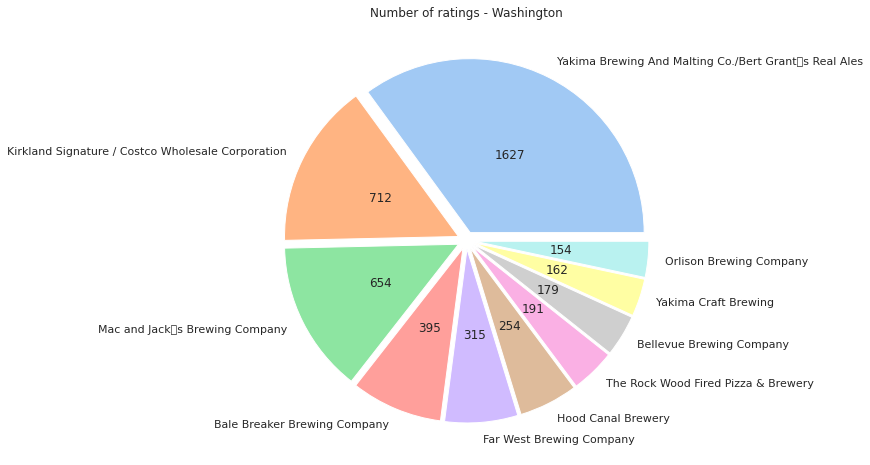

In [368]:
#Plot the pie charts
plot_pie_chart(top_10_popular_w.nb_ratings, top_10_popular_w.name, 'Number of ratings - Washington', 'i')

Yakima Brewing and Malting Co. devance de lui ses concurrents avec 1627 ratings, soit 2 fois plus que la brasserie juste derrière elle. Kirkland Signature et Mac and Jack's Brewing Company sont ensuite assez proches avec 712 et 654 ratings. Les autres brasseries, quant à elle, ont un nombre moins significatif de ratings. 

De la même manière que dans la partie précédente, nous allons assigner des scores à chaque brasserie pour déterminer ensuite quelles sont les brasseries les plus fortes sur le marché. 


In [401]:
#Add the score to the res DataFrame
cpt = 0
for index, row in top_10_popular_w.iterrows() : 
  id = row['brewery_id']
  if cpt == 0 : 
    res_breweries_w.at[id_to_index_w[id], 'nb_ratings'] = 5
  if cpt in [1,2] : 
    res_breweries_w.at[id_to_index_w[id], 'nb_ratings'] = 3
  if cpt in [3, 4, 5] : 
    res_breweries_w.at[id_to_index_w[id], 'nb_ratings'] = 2
  else : 
    res_breweries_w.at[id_to_index_w[id], 'nb_ratings'] = 1
  cpt += 1

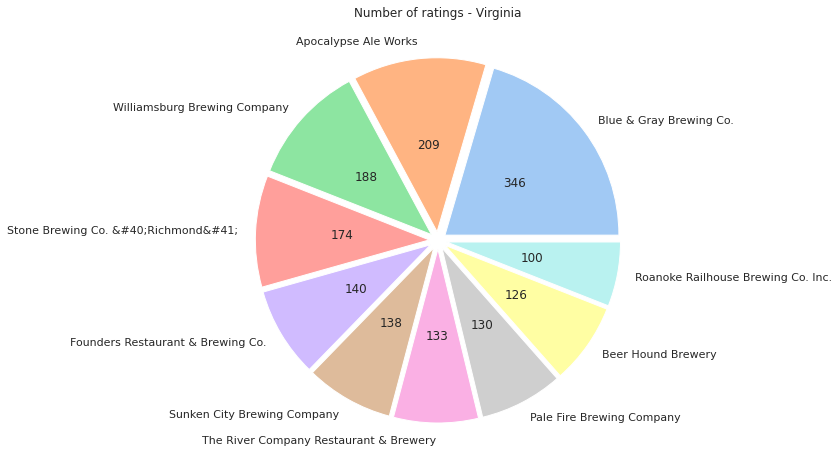

In [335]:
plot_pie_chart(top_10_popular_v.nb_ratings, top_10_popular_v.name, 'Number of ratings - Virginia', 'i')

Le répartition est plus uniforme en Viriginia, ce qui n'est pas étonnant car il s'agit de l'Etat avec le plus de brasseries sur le territoire et donc moins de leaders comme à Washington. Nous pouvons cependant noter que Blue & Gray Co. domine légérement le marché. 

In [400]:
#Add the score to the res DataFrame
cpt = 0
for index, row in top_10_popular_v.iterrows() : 
  id = row['brewery_id']
  if cpt == 0 : 
    res_breweries_v.at[id_to_index_v[id], 'nb_ratings'] = 3
  if cpt in [1, 2, 3] : 
    res_breweries_v.at[id_to_index_v[id], 'nb_ratings'] = 2
  else : 
    res_breweries_v.at[id_to_index_v[id], 'nb_ratings'] = 1
  cpt += 1

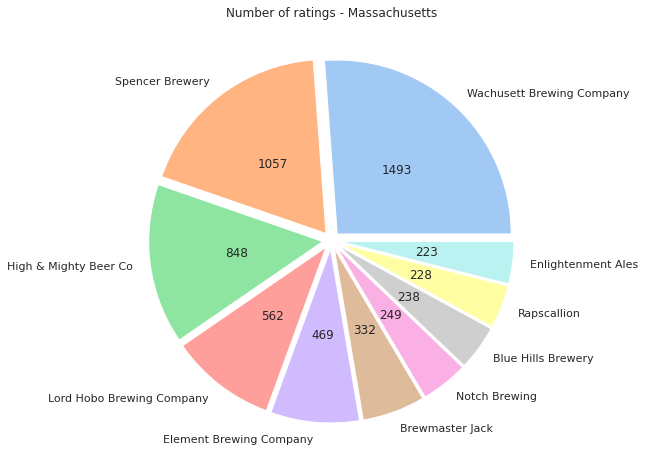

In [337]:
plot_pie_chart(top_10_popular_m.nb_ratings, top_10_popular_m.name, 'Number of ratings - Massachusetts', 'i')

Les 3 premières brasseries se partagent ici plus de la moitié des ratings des 10 brasseries les plus populaires. Lord Hobo Brewing Company et Element Brewing Company ont quant à elles un nombre un plus élevé que les autres brasseries mais de manière moins signifiante. 

Nous pouvons d'ailleurs noter que le nombre de ratings pour toutes les brasseries au Massachussetts est bien plus élevé que dans les 2 autres Etats. Les consommateurs semblent donc très investis dans la beer community. 


In [399]:
#Add the score to the res DataFrame
cpt = 0
for index, row in top_10_popular_m.iterrows() : 
  id = row['brewery_id']
  if cpt == 0 : 
    res_breweries_m.at[id_to_index_m[id], 'nb_ratings'] = 5
  if cpt == 1 : 
    res_breweries_m.at[id_to_index_m[id], 'nb_ratings'] = 4
  if cpt == 2 : 
    res_breweries_m.at[id_to_index_m[id], 'nb_ratings'] = 3
  if cpt in [3, 4] : 
    res_breweries_m.at[id_to_index_m[id], 'nb_ratings'] = 2
  else : 
    res_breweries_m.at[id_to_index_m[id], 'nb_ratings'] = 1
  cpt += 1

In [403]:
res_part2['Popular concurrents'] = [-2, 1, -1]
res_part2

,state,Users & Breweries,Evolution users,Percentage local,Ratings per user,Total score,Concurrent breweries,Popular concurrents,Successfull concurrents,Old concurrents,Local concurrents
46,Washington,0,1,1,2,4,9,-2,0,0,0
45,Virginia,0,2,2,0,4,33,1,0,0,0
20,Massachusetts,1,1,1,0,3,12,-1,0,0,0


##### **Highest average rating**

In [339]:
def best_rated_breweries(ratings, breweries) : 
  """Returns a DataFrame containing the 10 breweries with the highest average rating"""
  #Average rating
  avg_ratings_per_brewery = ratings.groupby('brewery_id').rating.mean()
  avg_ratings_per_brewery_df = pd.DataFrame({'brewery_id' : avg_ratings_per_brewery.index, 
                                            'avg_ratings' : avg_ratings_per_brewery.values})
  #Keep the columns we are interested in
  breweries_tmp = breweries[['name', 'brewery_id']]

  #Retrieve the name of the brewery
  avg_ratings_per_brewery_df = avg_ratings_per_brewery_df.merge(breweries_tmp, how='inner', on = 'brewery_id')
  
  #Retrieve the breweries with the highest avg rating
  avg_ratings_per_brewery_df.sort_values('avg_ratings', ascending=False, inplace=True)
  top_10_ratings = avg_ratings_per_brewery_df.head(10)

  return top_10_ratings

In [340]:
#Find the top 10 breweries with the highest number of ratings
top_10_ratings_w = best_rated_breweries(ratings_w, breweries_w)
top_10_ratings_v = best_rated_breweries(ratings_v, breweries_v)
top_10_ratings_m = best_rated_breweries(ratings_m, breweries_m)

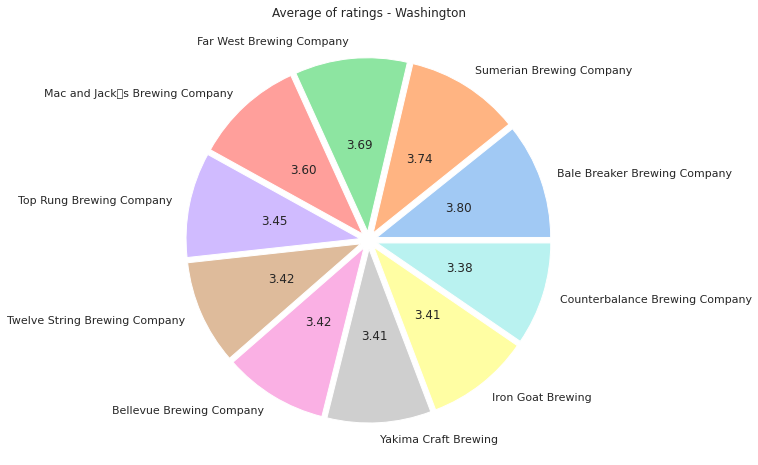

In [341]:
plot_pie_chart(top_10_ratings_w.avg_ratings, top_10_ratings_w.name, 'Average of ratings - Washington', 'f')

La différence dans la moyenne des ratings n'est pas vraiment marquée ici. En particulier, l'écart entre la 5e et la 10e brasserie est de seulement 0.07. Nous allons donner un score de 2 pour les 4 premières brasseries puis un score de 1 pour les 6 dernières. 

In [405]:
#Add the score to the res DataFrame
cpt = 0
for index, row in top_10_ratings_w.iterrows() : 
  id = row['brewery_id']
  if cpt == [0, 1, 2, 3, 4] : 
    res_breweries_w.at[id_to_index_w[id], 'avg_ratings'] = 2
  else : 
    res_breweries_w.at[id_to_index_w[id], 'avg_ratings'] = 1
  cpt += 1

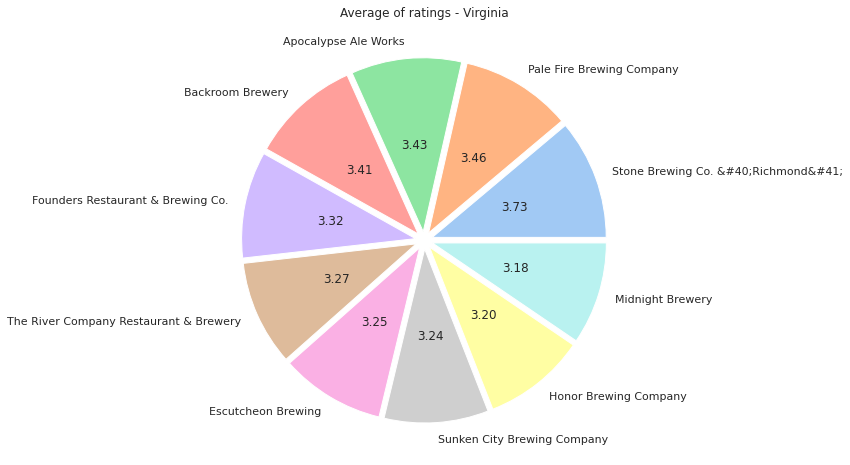

In [343]:
plot_pie_chart(top_10_ratings_v.avg_ratings, top_10_ratings_v.name, 'Average of ratings - Virginia', 'f')

La différence entre la moyenne des ratings de la première et de la 10e brasserie est un peu plus marquée ici qu'à Washington (~ 0.55). Il est difficile ici de regrouper des brasseries en fonction des chiffres ici car l'augmentation entre chacune des moyennes augmente de manière uniforme entre chaque brasserie. 

Stone Brewing Co semble tout de même légèrement dominer avec une moyenne de 3.73. 

In [406]:
#Add the score to the res DataFrame
cpt = 0
for index, row in top_10_ratings_v.iterrows() : 
  id = row['brewery_id']
  if cpt == 0 : 
    res_breweries_v.at[id_to_index_v[id], 'avg_ratings'] = 3
  if cpt in [1, 2, 3, 4] : 
    res_breweries_v.at[id_to_index_v[id], 'avg_ratings'] = 2
  else : 
    res_breweries_v.at[id_to_index_v[id], 'avg_ratings'] = 1
  cpt += 1

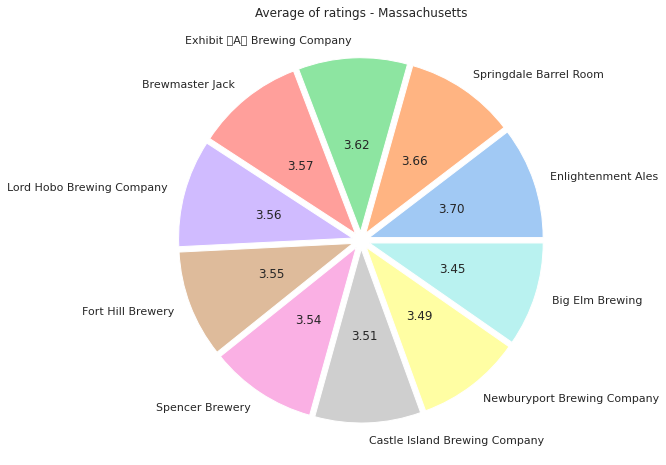

In [345]:
plot_pie_chart(top_10_ratings_m.avg_ratings, top_10_ratings_m.name, 'Average of ratings - Massachusetts', 'f')

Ici aussi, le rating moyen augmente de manière uniforme d'une brasserie à l'autre et il est difficile de faire du clustering. Nous allons donc attribuer un score de 2 aux 5 premières brasseries puis un score de 1 aux 5 suivantes. 

In [408]:
#Add the score to the res DataFrame
cpt = 0
for index, row in top_10_ratings_m.iterrows() : 
  id = row['brewery_id']
  if cpt in [i for i in range(5)] : 
    res_breweries_m.at[id_to_index_m[id], 'avg_ratings'] = 2
  else :
    res_breweries_m.at[id_to_index_m[id], 'avg_ratings'] = 1
  cpt += 1

##### **Number of years since the first rating**

In [349]:
def years_since_first_review(breweries) : 
  """Returns a DataFrame containing the 10 breweries which have the longest period between first review and now"""
  #Breweries we are keeping
  breweries_ids = breweries.brewery_id.values.tolist()

  #Retrieve first and last years of ratings for each brewery
  first_last_years = first_last_years_df[first_last_years_df['brewery_id'].isin(breweries_ids)]

  #Add a column which contains the difference between last year and first year 
  first_last_years['diff'] = first_last_years['last_year'] - first_last_years['first_year']
  years_df = pd.DataFrame({'brewery_id' : first_last_years.brewery_id.values.tolist(), 
                            'diff' : first_last_years['diff'].values.tolist()
                          })
  
  #Keep the columns we are interested in
  breweries_tmp = breweries[['name', 'brewery_id']]

  #Retrieve the name of the brewery
  years_df = years_df.merge(breweries_tmp, how='inner', on = 'brewery_id')
  
  #Retrieve the breweries with the highest avg rating
  years_df.sort_values('diff', ascending=False, inplace=True)
  top_10_years = years_df.head(10)

  return top_10_years

In [350]:
#Find the top 10 breweries with the highest number of ratings
top_10_years_w = years_since_first_review(breweries_w)
top_10_years_v = years_since_first_review(breweries_v)
top_10_years_m = years_since_first_review(breweries_m)

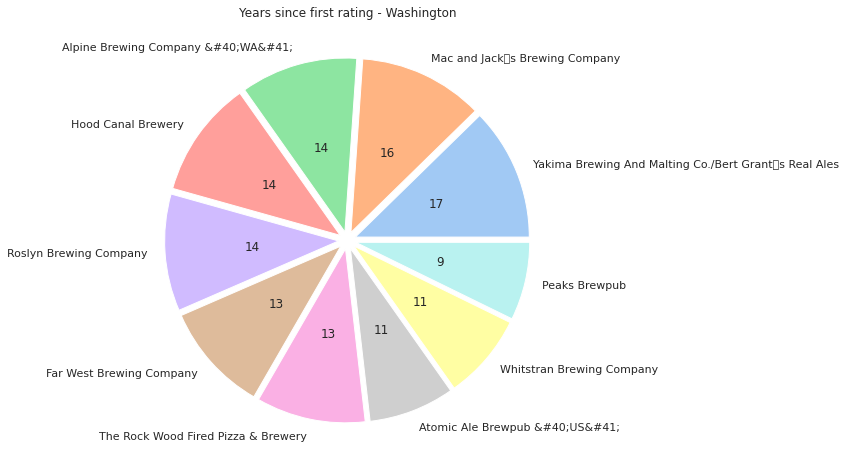

In [351]:
plot_pie_chart(top_10_years_w['diff'], top_10_years_w.name, 'Years since first rating - Washington', 'i')

La 10 brasseries les plus anciennes dans les commentaires sont ancrées sur le territoire depuis longtemps : 17 ans pour la première, 16 pour la deuxième, et 14 pour les 3 suivantes ! Cependant, la répartition est assez uniforme entre ces 10 brasseries, signifiant qu'aucune brasserie ne se démarque significative des autres par son ancienneté. 

Ce type de brasseries peuvent être de réelles concurrents car elles sont connues de la population et que les produits plaisent, sachant qu'il existe encore des ratings sur leurs produits aujourd'hui. Il se pourrait d'ailleurs que les utilisateurs de Washington n'aillent pas instinctivement vers de nouvelles brasseries et se tournent par habitude vers les brasseries reconnues dans l'Etat. 

In [422]:
#Add the score to the res DataFrame
cpt = 0
for index, row in top_10_years_w.iterrows() : 
  id = row['brewery_id']
  if cpt in [i for i in range(5)] : 
    res_breweries_w.at[id_to_index_w[id], 'nb_years_since_first_rating'] = 3
  else :
    res_breweries_w.at[id_to_index_w[id], 'nb_years_since_first_rating'] = 2
  cpt += 1

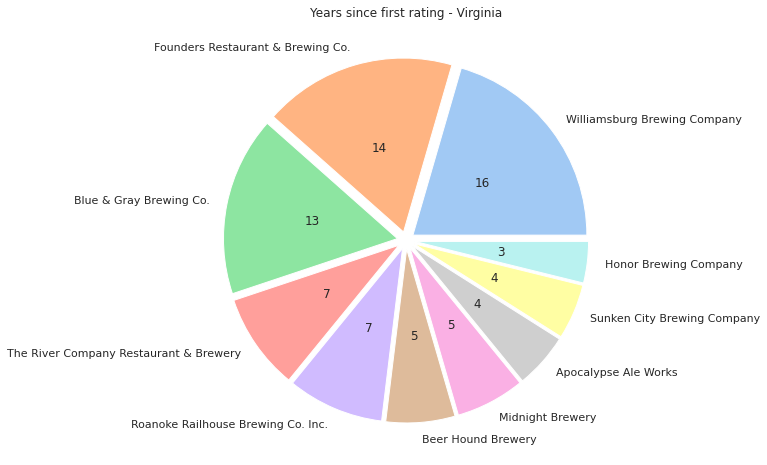

In [112]:
plot_pie_chart(top_10_years_v['diff'], top_10_years_v.name, 'Years since first rating - Virginia', 'i')

La différence est bien plus marquée en Virginia qu'à Washington. Les 3 premières brasseries dominent le marché. Williamsburg Brewing Company, en tête se situe dans les commentaires depuis 16 ans, alors que la 10e brasserie a vu son premier commenatire naître depuis seulement 3 ans. 

La plupart des brasseries en Virginia sont donc très récentes, sachant d'ailleurs qu'il s'agit de l'Etat avec le nombre le plus important de potentiels concurrents (32 brasseries). Parmis ces 32 brasseries, seules persistent dans les commentaires depuis plus de 7 ans. 

Ainsi, à part les 3 brasseries reconnues en Virginia depuis 3 ans et qui pourraient représenter de forts concurrents, notre client sera capable de  de trouver plus facilement sa place sur le marché qu'à Washington, sachant d'ailleurs qu'il dispose du score le plus élevé concernant l'évolution du nombre de users depuis quelques années. 

In [409]:
#Add the score to the res DataFrame
cpt = 0
for index, row in top_10_years_v.iterrows() : 
  id = row['brewery_id']
  if cpt in [i for i in range(3)] : 
    res_breweries_v.at[id_to_index_v[id], 'nb_years_since_first_rating'] = 3
  else :
    res_breweries_v.at[id_to_index_v[id], 'nb_years_since_first_rating'] = 1
  cpt += 1

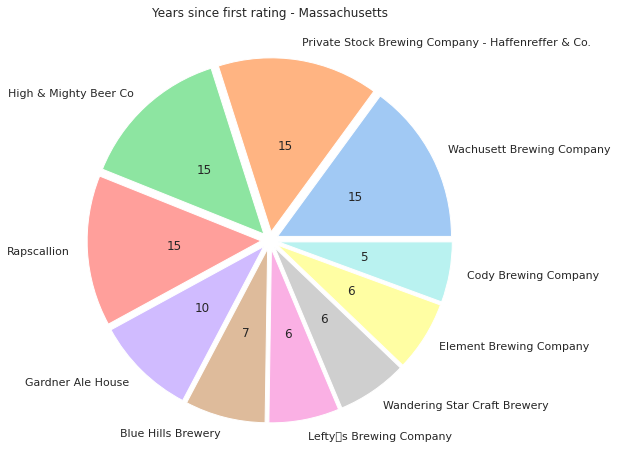

In [353]:
plot_pie_chart(top_10_years_m['diff'], top_10_years_m.name, 'Years since first rating - Massachusetts', 'i')

Au Massachussetts, 4 brasseries sont présentes dans les commentaires depuis 15 ans et dominent les autres brasseries dans le top 10. Mis à part Gardner Ale House, la période depuis le premier rating est 2 fois plus élevée que dans les autres brasseries. 

Nous retrouvons le même schéma qu'en Virginia, avec seulement 5 brasseries apparaissant dans les commentaires depuis plus de 10 ans. Ces dernières sont donc à surveiller, mais le marché est plutôt propice pour notre client. 

In [354]:
#Add the score to the res DataFrame
cpt = 0
for index, row in top_10_years_m.iterrows() : 
  id = row['brewery_id']
  if cpt in [i for i in range(4)] : 
    res_breweries_m.at[id_to_index_m[id], 'nb_years_since_first_rating'] = 3
  if cpt == 5 : 
    res_breweries_m.at[id_to_index_m[id], 'nb_years_since_first_rating'] = 2
  else :
    res_breweries_m.at[id_to_index_m[id], 'nb_years_since_first_rating'] = 1
  cpt += 1

In [410]:
res_part2['Old concurrents '] = [-2, 1, 1]
res_part2

,state,Users & Breweries,Evolution users,Percentage local,Ratings per user,Total score,Concurrent breweries,Popular concurrents,Successfull concurrents,Old concurrents,Local concurrents
46,Washington,0,1,1,2,4,9,-2,0,-2,0
45,Virginia,0,2,2,0,4,33,1,0,1,0
20,Massachusetts,1,1,1,0,3,12,-1,0,1,0


##### **Which are the local breweries ?**

In [114]:
def most_popular_breweries(breweries) : 
  """Returns a DataFrame containing the 10 breweries with the highest percentage of local ratings"""
  breweries_ids = breweries.brewery_id.values.tolist()
  local_df_tmp = local_df.loc[local_df['brewery_id'].isin(breweries_ids)]
  us_df_tmp = us_df.loc[us_df['brewery_id'].isin(breweries_ids)]

  #Count the number of local ratings per brewery
  local_per_brewery = local_df_tmp.groupby('brewery_id').beer_id.count().to_dict()

  #Count the number of ratings from US per brewery
  us_per_brewery = us_df_tmp.groupby('brewery_id').beer_id.count().to_dict()

  #Add 0 if there is no local ratings
  for key, value in us_per_brewery.items() :
    if key not in local_per_brewery :
      local_per_brewery[key] = 0
  
  local_per_brewery = dict(sorted(local_per_brewery.items()))
  us_per_brewery = dict(sorted(us_per_brewery.items()))

  assert(len(local_per_brewery) == len(us_per_brewery))

  local_per_brewery_df = pd.DataFrame({'brewery_id' : us_per_brewery.keys(), 
                                    'nb_local' : local_per_brewery.values(), 
                                    'nb_us' : us_per_brewery.values()
                                    })
  local_per_brewery_df['percentage_local'] = 100 * local_per_brewery_df['nb_local'] / local_per_brewery_df['nb_us']

  #Keep the columns we are interested in
  breweries_tmp = breweries[['name', 'brewery_id']]

  local_per_brewery_df = local_per_brewery_df[['brewery_id', 'percentage_local']]

  #Retrieve the name of the brewery
  local_per_brewery_df = local_per_brewery_df.merge(breweries_tmp, how='inner', on = 'brewery_id')

  #Retrieve the breweries with the highest avg rating
  local_per_brewery_df.sort_values('percentage_local', ascending=False, inplace=True)
  top_10_years = local_per_brewery_df.head(10)

  return top_10_years


In [115]:
#Find the top 10 breweries with the highest number of ratings
top_10_local_w = most_popular_breweries(breweries_w)
top_10_local_v = most_popular_breweries(breweries_v)
top_10_local_m = most_popular_breweries(breweries_m)

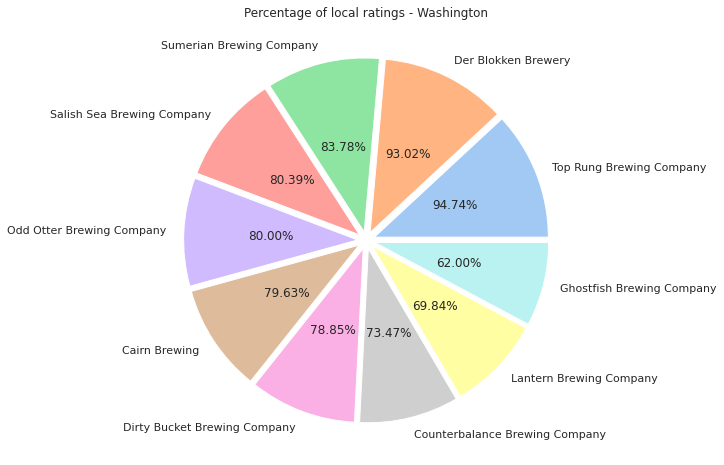

In [355]:
plot_pie_chart(top_10_local_w['percentage_local'], top_10_local_w.name, 'Percentage of local ratings - Washington', 'per')

Le pourcentage de ratings venant des consommateurs du même état que la brasserie est très élevé pour ces 10 brasseries, allant de 62% pour la 10th jusqu'à presque 95% pour Top Rung Brewing Company en tête. La population à Washington est donc un public qui aime beaucoup les bières locales, ce qui est semble être très intéressant pour notre client. 

In [418]:
#Add the score to the res DataFrame
cpt = 0
for index, row in top_10_local_w.iterrows() : 
  id = row['brewery_id']
  if cpt in [0, 1] : 
    res_breweries_w.at[id_to_index_w[id], 'percentage_local_users'] = 4
  if cpt == 2 : 
    res_breweries_w.at[id_to_index_w[id], 'percentage_local_users'] = 3
  if cpt in [i for i in range(3, 7)] : 
    res_breweries_w.at[id_to_index_w[id], 'percentage_local_users'] = 2
  else :
    res_breweries_w.at[id_to_index_w[id], 'percentage_local_users'] = 1
  cpt += 1

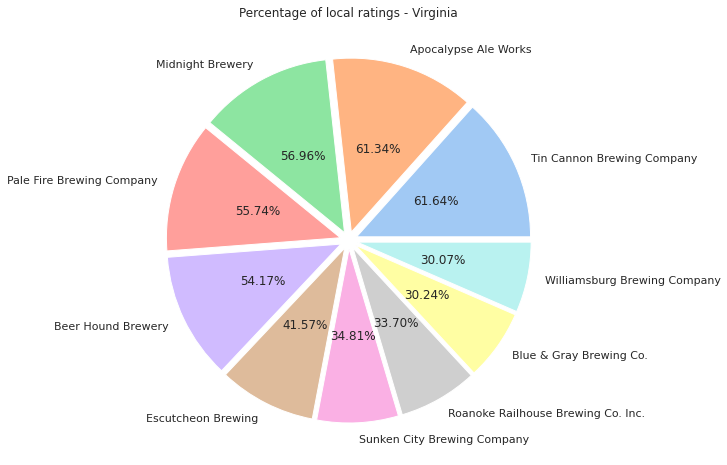

In [357]:
plot_pie_chart(top_10_local_v['percentage_local'], top_10_local_v.name, 'Percentage of local ratings - Virginia', 'per')

Le pourcentage de ratings locaux est bien moins élevé en Virginia qu'à Washington. En effet, seuls 61% des ratings sont locaux pour la première brasserie alors que la 10th brasserie à Washington disposait de 62% de ratinsg locaux. Cependant, la population en Virginia semble intéressée par les bières locales et notre client pour se positionner en tant que leader sur le marché avec sa brasserie. Les potentiels concurrents ici seraient les 5 premières brasseries arrivant en tête du classement qui ont un pourcentage de ratings, avec tout de même une préférence pour Tin Cannon Brewing Company et Apocalypse Ale Works. 


In [419]:
#Add the score to the res DataFrame
cpt = 0
for index, row in top_10_local_v.iterrows() : 
  id = row['brewery_id']
  if cpt in [0,1] : 
    res_breweries_v.at[id_to_index_v[id], 'percentage_local_users'] = 3
  if cpt in [2,3,4] : 
    res_breweries_v.at[id_to_index_v[id], 'percentage_local_users'] = 2
  else :
    res_breweries_v.at[id_to_index_v[id], 'percentage_local_users'] = 1
  cpt += 1

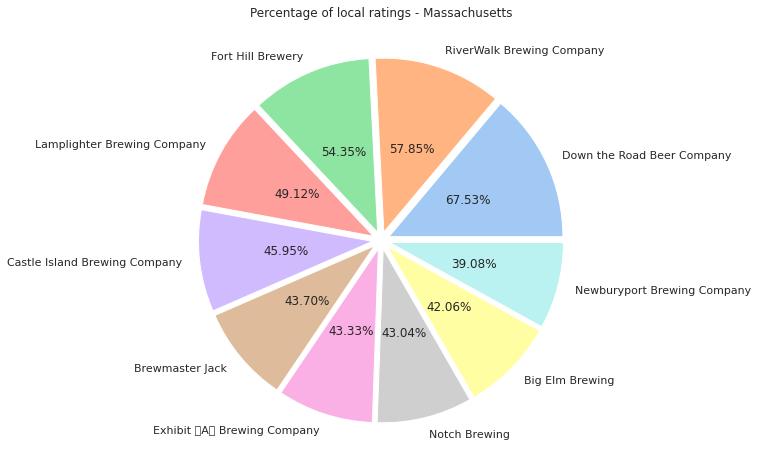

In [358]:
plot_pie_chart(top_10_local_m['percentage_local'], top_10_local_m.name, 'Percentage of local ratings - Massachusetts', 'per')

De même que pour Virginia, la tendance pour le local est moins marquée qu'à Washington. D'ailleurs, le pourcentage de ratings locaux est assez serré pour les brasseries dans le top 10. Down the Road Beer Company se démarque tout de même des autres brasseries. 

In [420]:
#Add the score to the res DataFrame
cpt = 0
for index, row in top_10_local_m.iterrows() : 
  id = row['brewery_id']
  if cpt == 0 : 
    res_breweries_m.at[id_to_index_m[id], 'percentage_local_users'] = 3
  if cpt in [1,2] : 
    res_breweries_m.at[id_to_index_m[id], 'percentage_local_users'] = 2
  else :
    res_breweries_m.at[id_to_index_m[id], 'percentage_local_users'] = 1
  cpt += 1

In [415]:
res_part2['Local concurrents '] = [2, 1, 1]
res_part2

,state,Users & Breweries,Evolution users,Percentage local,Ratings per user,Total score,Concurrent breweries,Popular concurrents,Successfull concurrents,Old concurrents,Local concurrents
46,Washington,0,1,1,2,4,9,-2,0,-2,2
45,Virginia,0,2,2,0,4,33,1,0,1,1
20,Massachusetts,1,1,1,0,3,12,-1,0,1,1


#####**Results**

In [524]:
def compute_total(res_df, state) :
  """Compute the total scores for each brewery""" 
  total_column = []

  #Replace nb_concurrents by score
  if state : 
    res_df['Concurrent breweries'] = [-1, 0, 0]

  for index, row in res_df.iterrows() : 
    total=0
    for column in res_df.columns[2:-1] : 
      total +=  row[column]
    total_column.append(total)

  if state : 
    res_df['Total score 2'] = total_column
    res_df = res_df.sort_values('Total score 2', ascending = False)
  else : 
    res_df['Total score'] = total_column
    res_df = res_df.loc[res_df['Total score'] > 0].sort_values('Total score', ascending = False)
    print(len(res_df), 'potential concurrents')
    
  return res_df

In [563]:
res_w = compute_total(res_breweries_w, 0).drop(columns = ['id']).set_index('name').head(5)

fig = make_subplots(rows=1, cols=3)
fig1 = px.bar(res_w, x=res_w.index, y=res_w.nb_ratings)
fig2 = px.bar(res_w, x=res_w.index, y=res_w.avg_ratings)
fig3 = px.bar(res_w, x=res_w.index, y=res_w.nb_years_since_first_rating)


fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig2['data'][0], row=1, col=2)
fig.add_trace(fig3['data'][0], row=1, col=3)

fig.show()

27 potential concurrents


In [558]:
res_v = compute_total(res_breweries_v, 0).drop(columns = ['id']).set_index('name').head(5)
fig = px.hist(res_v, x=res_v.index, y=res_v.columns.values.tolist(), title="Virginia - Top 5 potential concurrents", text_auto=True)
fig.show()

15 potential concurrents


AttributeError: ignored

In [559]:
fig = px.histogram(res_w_tmp, x=res_w_tmp.index, y=res_w_tmp.columns.values.tolist()[1:], title="Top 5 potential concurrents")
fig.show()

In [526]:
res_v = compute_total(res_breweries_v, 0)
res_v.head(10)

15 potential concurrents


,name,id,nb_ratings,avg_ratings,nb_years_since_first_rating,percentage_local_users,Total score
0,Apocalypse Ale Works,16126,2,2,1,1,6
12,Founders Restaurant & Brewing Co.,4058,1,2,3,0,6
14,Williamsburg Brewing Company,1555,2,0,3,1,6
3,Blue & Gray Brewing Co.,3785,1,0,3,1,5
7,Pale Fire Brewing Company,22671,1,2,0,2,5
2,Beer Hound Brewery,15360,1,0,1,2,4
6,Midnight Brewery,14586,0,1,1,2,4
9,Sunken City Brewing Company,17023,1,1,1,1,4
8,Stone Brewing Co. &#40;Richmond&#41;,28030,2,1,0,0,3
10,The River Company Restaurant & Brewery,10600,1,1,1,0,3


In [435]:
res_m = compute_total(res_breweries_m, 0)
res_m.head(10)

19 potential concurrents


,name,id,nb_ratings,avg_ratings,nb_years_since_first_rating,percentage_local_users,Total score
14,Lord Hobo Brewing Company,23213,2,2,0,0,4
4,Brewmaster Jack,14942,1,2,0,1,4
25,Enlightenment Ales,14905,1,2,0,0,3
8,Exhibit A Brewing Company,28053,0,2,0,1,3
9,Fort Hill Brewery,21684,0,1,0,2,3
21,Springdale Barrel Room,30344,0,2,0,0,2
20,Spencer Brewery,18289,1,1,0,0,2
19,RiverWalk Brewing Company,15704,0,0,0,2,2
16,Notch Brewing,12650,1,0,0,1,2
15,Newburyport Brewing Company,16347,0,1,0,1,2


In [443]:
res_part2 = compute_total(res_part2, 1)
res_part2

,state,Users & Breweries,Evolution users,Percentage local,Ratings per user,Total score,Concurrent breweries,Popular concurrents,Successfull concurrents,Old concurrents,Local concurrents,Total score 2
45,Virginia,0,2,2,0,4,-1,1,0,1,1,10
20,Massachusetts,1,1,1,0,3,0,-1,0,1,1,6
46,Washington,0,1,1,2,4,0,-2,0,-2,2,6


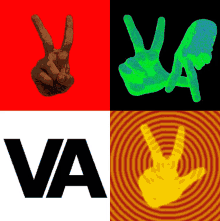

---



In [522]:
#res_final = res_part2.set_index('state')
res_final = res_part2.drop(columns = 'Successfull concurrents', axis=1)
res_final = res_final.T
res_final = res_final.sort_values(' Virginia', ascending=False)
res_final = res_final.iloc[2:]
res_final

state,Virginia,Massachusetts,Washington
Evolution users,2,1,1
Percentage local,2,1,1
Popular concurrents,1,-1,-2
Old concurrents,1,1,-2
Local concurrents,1,1,2
Users & Breweries,0,1,0
Ratings per user,0,0,2
Concurrent breweries,-1,0,0


In [523]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3, shared_yaxes=True)

fig.add_trace(go.Bar(x=res_final[' Virginia'].values,
                     y=res_final.index,
                     orientation='h',
                     name='Virginia'), row=1, col=1)

fig.add_trace(go.Bar(x=res_final[' Massachusetts'].values,
                     y=res_final.index,
                     orientation='h',
                     name='Massachusetts'), row=1, col=2)

fig.add_trace(go.Bar(x=res_final[' Washington'].values,
                     y=res_final.index,
                     orientation='h',
                     name='Washington'), row=1, col=3)

fig.add_vline(x=0)

fig.update_layout(barmode='relative', 
                  height=500, 
                  width=1200, 
                  yaxis_autorange='reversed',
                  bargap=0.01,
                  legend_orientation ='h',
                  legend_x=-0.05, legend_y=1.1,
                  title_text='Scores of the 3 recommended states'
                  )
fig

In [ ]:
fig.add_trace(go.Bar(x=res_final[' Massachusetts'].values,
                     y=res_final.index,
                     orientation='h',
                     name='Virginia'))

In [466]:
#Retrieve data from Virginia 

res_virginia = res_part2.iloc[0]
res_virginia_df = pd.DataFrame({'Properties' : res_virginia.index[1:-1], 'score' : res_virginia.values[1:-1]})
res_virginia_df

KeyError: ignored

#### **Which beers in the top 3 states are most similar to our products?**
Amine - Your part 

## **Part 3 - Our suggestions to lead the market**

Maintenant que nous avons identifié les états les plus favorables où notre client devrait installer sa brasserie et déterminer les principaux concurrents dans chaque Etat, nous allons proposer une stratégie à notre client afin qu'il puisse se positionner sur le marché et surpasser ses concurrents. 

🍻 La recette du succès    
La conccurence est de plus en plus forte aux Etats-Unis dans le secteur de la bière depuis plusieurs années. Il est donc primordial pour notre client de définir une stratégie afin de se démarquer des autres brasseries et de perdurer au cours des années. 

En effet, comme nous avons pu le voir lors de notre analyse globale du marché, suite à la grosse hype aux Etats Unis autour de la bière entre 2012 et 2014, les brasseries ont sauté sur l'occasion et des centaines sont apparues tous les ans jusqu'à atteindre le nombre de 841 nouvelles brasseries dans les commentaires en 2016. Cependant, 730 brasseries n'apparaissent plus dans les commentaires en 2016. 

Le point clé de notre stratégie sera donc de faire en sorte que notre client ait un produit phare qui lui permettra d'entrer sur le marché avec succès mais également de perdurer au cours du temps. 


🤔 Mais comment définir ce produit ? 

Tout d'abord, le produit doit être un produit qui va plaire aux consommateurs. L'objectif ici n'est pas d'être original. Au contraire, nous devons choisir un style ancré dans les Etats où notre client va potentiellement installer sa brasserie. Nous cherchons une valeur sûre, une bière vers laquelle les clients vont se tourner et vouloir racheter car il s'agit de leur style préféré. 

Il faut ensuite que notre produit se démarque des bières concurrentes. Les consommateurs doivent trouver ce petit plus dans notre produit qui n'est pas présent dans les autres bières du même style, ce qui nous permettra de nous démarquer et de potentiellement toucher les clients des brasseries concurrentes. 


✏️ Notre stratégie

Pour aider notre client dans l'élaboration de son produit phare, nous allons suivre la stratégie suivante :    


1.   **Jo**: Trouver les styles ancrés dans chaque Etat
2.   **Anne** : Déterminer quelles sont les bières les plus aimées dans chaque style 
> Nb ratings 
> Avg rating
3.   **Amine** : Trouver quelles sont les caractéristiques (aroma, palate, savor, appearance, taste,...) de ces bières qui influent le plus sur la note des ratings
> Linear Regression
4.   **Amine** : Trouver les mots qui ressortent le plus dans les commentaires sur ces bières 
> Word Cloud
5.   **Anne ou Amine** : (Etudier les caractéristiques techniques de ces bières --> via le site avec la composition de chaque bière) 
6.   **Amine** : Proposer une recette afin qu'elle se démarque des bières les plus aimées dans chaque style 
7.   Tester si avec ces nouvelles caractéristiques notre bière aura un meilleur rating 
> Linear Regression (en mode prédiction après avoir été train sur les commentaires) 



#### **Which style should we chose ?** 

##### **Which styles are most popular in each state?**

In [309]:
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

def styles_by_state(beers, ratings) : 
  """Returns all the styles present in each state"""
  #Keep only the columns beer_id and style from beers dataset 
  beers_tmp = beers[['beer_id', 'style']]

  #Add style of the beer to the ratings dataset 
  ratings = ratings.merge(beers_tmp, how='inner', on='beer_id') 

  return ratings

def plot_word_cloud_styles(ratings, title):
    """Plot Wordcloud reporting the importance of each style"""

    # exctract textual reviews
    styles = ratings['style']
    word_could_dict=Counter(styles)
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_could_dict)
    # display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20, y=1.08)

def create_counts_styles(ratings) : 
  """Create a DataFrame which contains the number of ratings per style"""
  ratings_tmp = ratings.groupby('style').beer_id.count()
  counts_styles_df = pd.DataFrame({'style' : ratings_tmp.index, 'counts' : ratings_tmp.values})
  counts_styles_df = counts_styles_df.sort_values('counts', ascending=False).head(5)
  return counts_styles_df

def barplot_styles(ratings, title) : 
  """Create a vertical barplot with the top 5 styles"""
  counts_styles_df = create_counts_styles(ratings)

  palette = sns.color_palette("pastel")
  sns.barplot(x="counts", y="style", data=counts_styles_df, palette = palette, label="Number of ratings")

  sns.despine(left=True, bottom=True)

  plt.tight_layout()
  plt.title(title)

def barplot_and_wordcloud(ratings, title_w, title_b) : 
  
  plt.figure(figsize=(20, 6))

  plt.subplot(1,2,1)
  plot_word_cloud_styles(ratings, title_w)

  plt.subplot(1,2,2)
  barplot_styles(ratings, title_b)

  plt.show()

#For each style we look at the evolution of the number of ratings over time 
def evolution_style(ratings) : 
  count_ratings_list = []

  #For each year
  for year in range(2007, 2017) :
    #Keep only the ratings from that year 
    df_tmp = ratings.loc[ratings['year']==year]
      
    #Group by the style and retrieve the number of ratings for this year
    count_rating = df_tmp.groupby('style').beer_id.count().to_dict()

    count_ratings_list.append(count_rating)
    
  return count_ratings_list

def plot_evolution(counts_ratings_df, green_list, red_list) : 
  fig, axs = plt.subplots(2, 5, figsize=(30,6), sharex=True, sharey=True)
  fig.suptitle('Evolution of the styles', fontsize=20)

  for i, elem in enumerate(counts_ratings_df.index):
      # Get the info on the plot
      row = i // 5
      col = i % 5
      subplot = axs[row, col]
      
      # Get the list of points
      counts_style = counts_ratings_df.iloc[i].values

      # Plot the evolution styles
      if elem in green_list : 
        subplot.plot(counts_ratings_df.columns, counts_style, color=green, marker = 'o')
      elif elem in red_list : 
        subplot.plot(counts_ratings_df.columns, counts_style, color=red, marker = 'o')
      else : 
        subplot.plot(counts_ratings_df.columns, counts_style, color=blue, marker = 'o')


      subplot.set_xticks([i for i in range(2007, 2017)])
      plt.setp(subplot.get_xticklabels(), rotation=45)
      subplot.set_title(elem, fontsize=10)
      subplot.grid(False)

  plt.show()



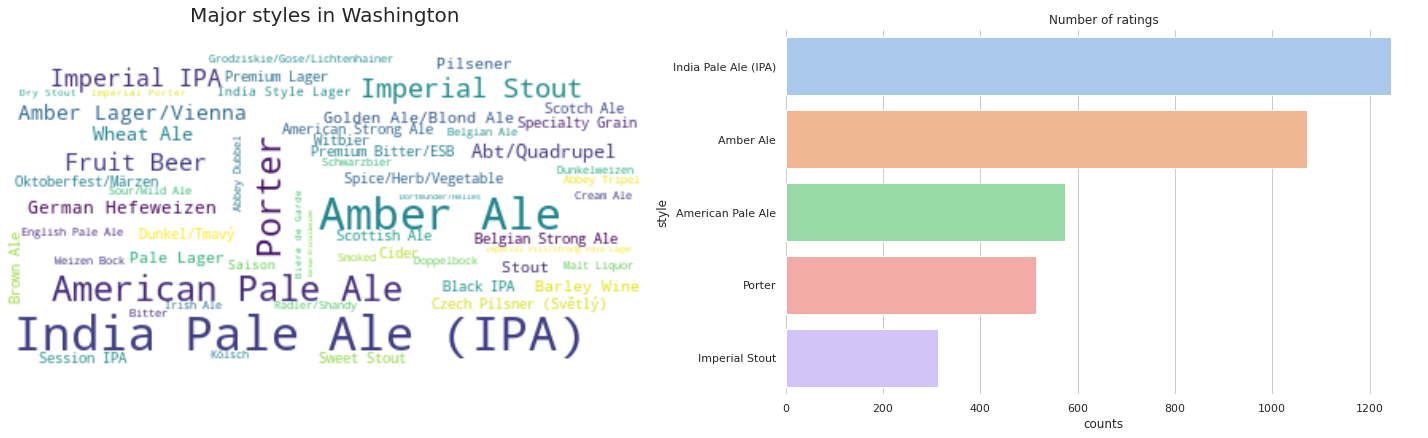

In [270]:
ratings_w = styles_by_state(beers_w, ratings_w) 
barplot_and_wordcloud(ratings_w, 'Major styles in Washington', 'Number of ratings')

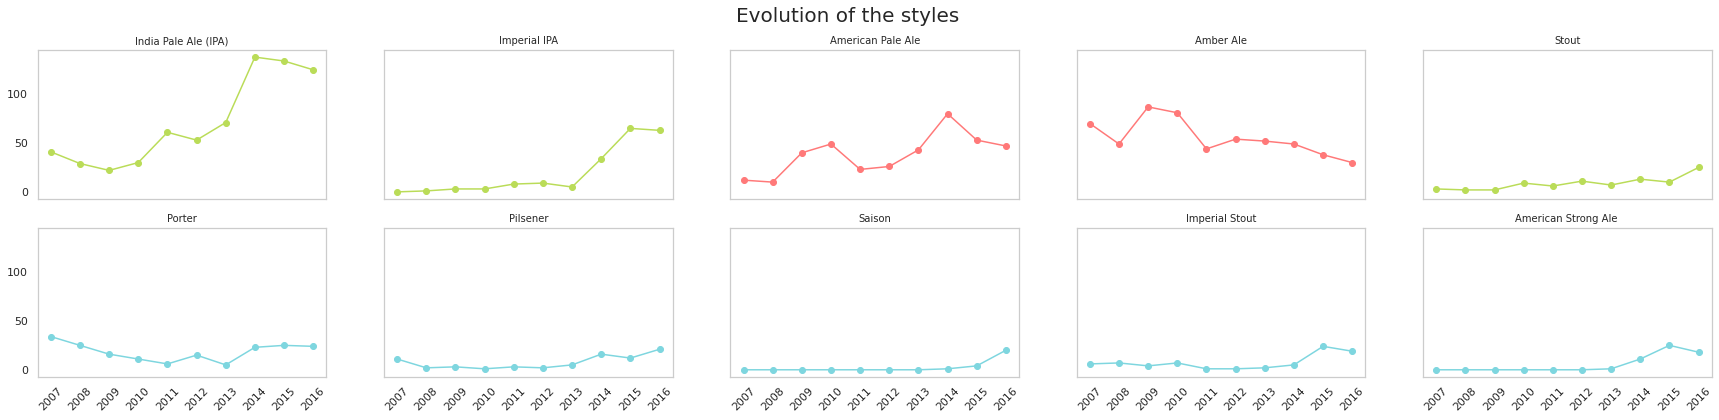

In [310]:
count_ratings_list_w = evolution_style(ratings_w)
counts_ratings_df_w = create_evolution_df(count_ratings_list_w).sort_index().sort_values(2016, ascending=False).head(10)
plot_evolution(counts_ratings_df_w, ['India Pale Ale (IPA)', 'Imperial IPA', 'Stout'], ['American Pale Ale', 'Amber Ale'])

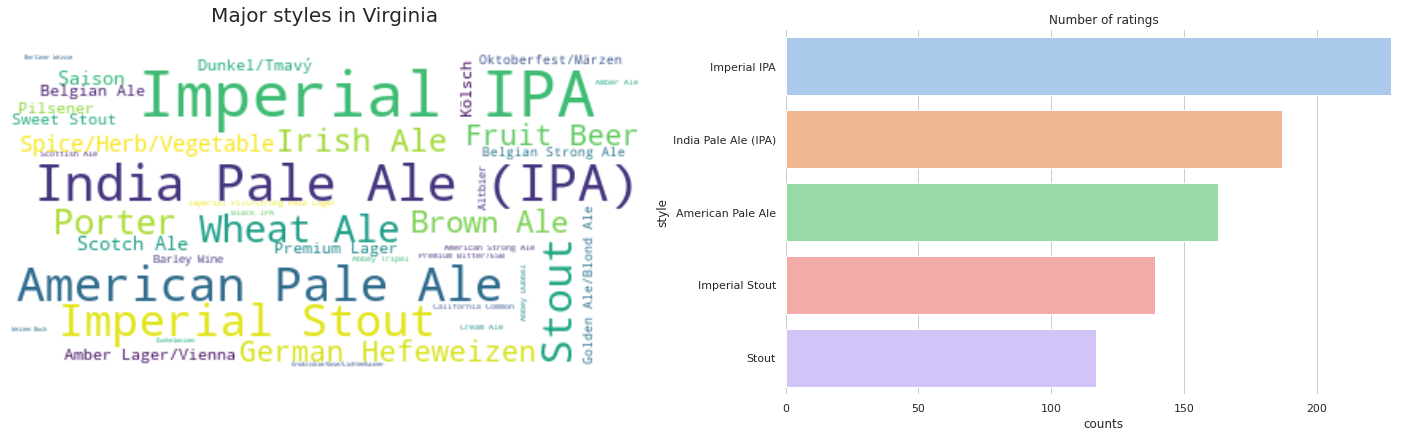

In [271]:
ratings_v = styles_by_state(beers_v, ratings_v) 
barplot_and_wordcloud(ratings_v, 'Major styles in Virginia', 'Number of ratings')

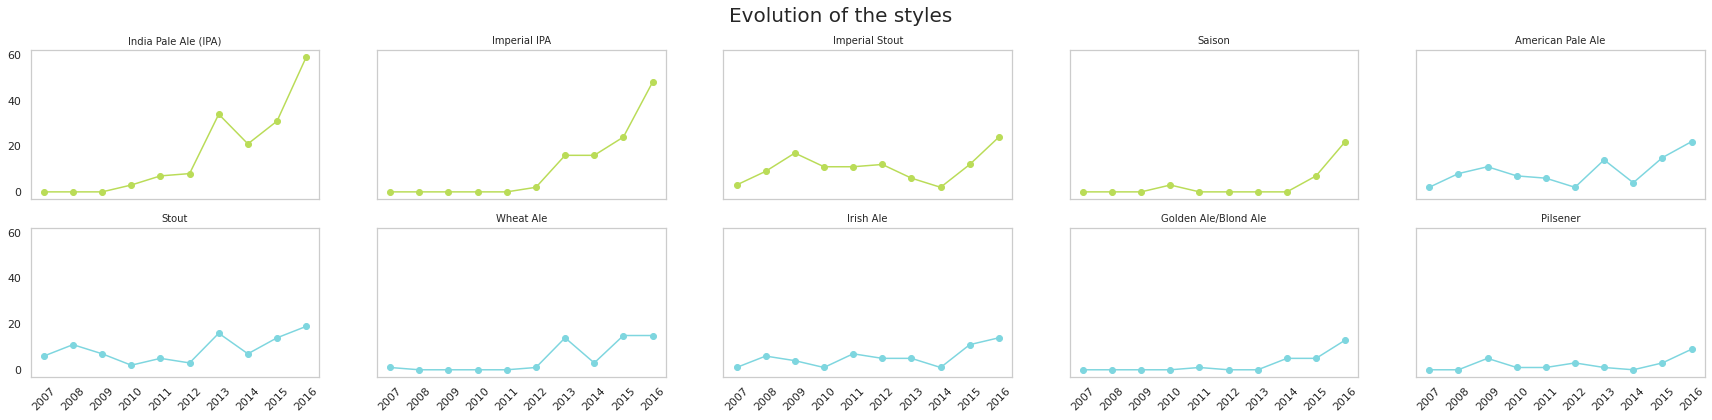

In [315]:
count_ratings_list_v = evolution_style(ratings_v)
counts_ratings_df_v = create_evolution_df(count_ratings_list_v).sort_index().sort_values(2016, ascending=False).head(10)
plot_evolution(counts_ratings_df_v, ['India Pale Ale (IPA)', 'Imperial IPA', 'Saison', 'Imperial Stout'], [])

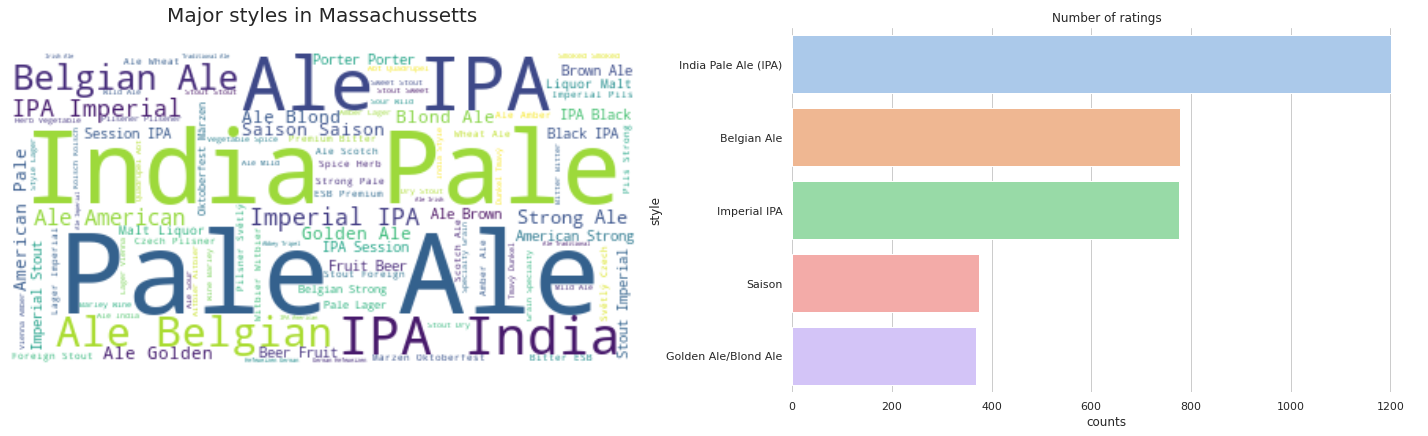

In [210]:
ratings_m = styles_by_state(beers_m, ratings_m) 
barplot_and_wordcloud(ratings_m, 'Major styles in Massachussetts', 'Number of ratings')

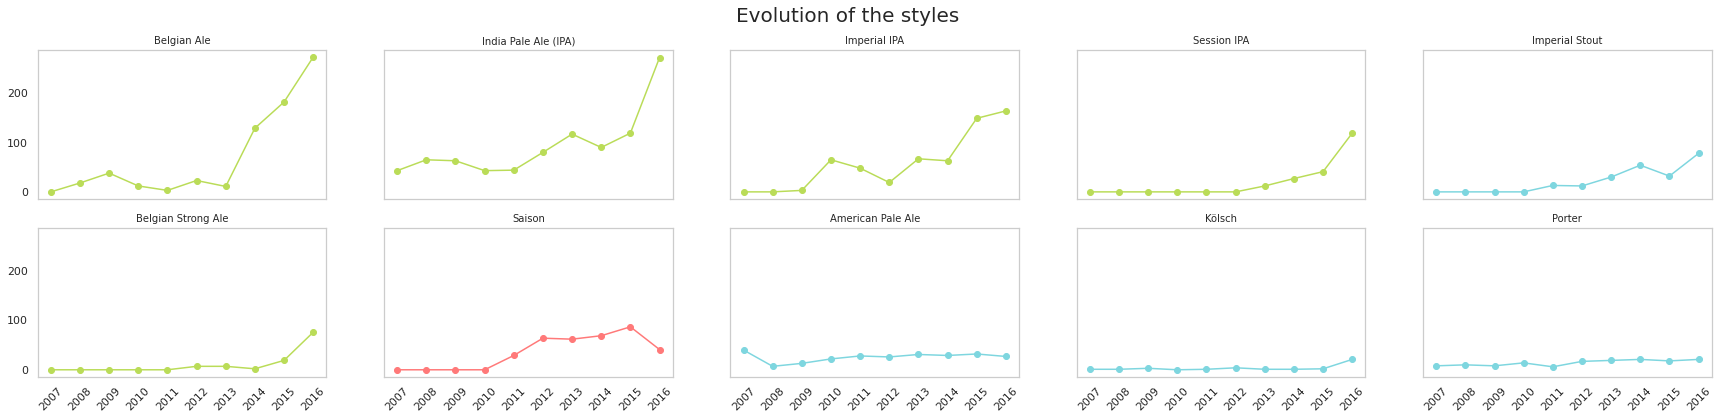

In [319]:
count_ratings_list_m = evolution_style(ratings_m)
counts_ratings_df_m = create_evolution_df(count_ratings_list_m).sort_index().sort_values(2016, ascending=False).head(10)
plot_evolution(counts_ratings_df_m, ['Belgian Ale', 'India Pale Ale (IPA)', 'Imperial IPA', 'Session IPA', 'Belgian Strong Ale'], ['Saison'])

Blabla to do.

